In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
# we utilise curve api endpoint to retrieve daily lending market data 
import requests 
import pandas as pd


def retrieve_lending_market(chain: str ='ethereum', controller_address: str = '0xeda215b7666936ded834f76f3fbc6f323295110a'):
    url = f'https://prices.curve.fi/v1/lending/markets/{chain}/{controller_address}/snapshots?fetch_on_chain=false&agg=day'
    r = requests.get(url)
    df =  pd.json_normalize(r.json()['data'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])  
    return df 


df = retrieve_lending_market()

Index(['rate', 'borrow_apy', 'lend_apy', 'liquidation_discount',
       'loan_discount', 'n_loans', 'price_oracle', 'amm_price', 'base_price',
       'total_debt', 'total_assets', 'total_debt_usd', 'total_assets_usd',
       'minted', 'redeemed', 'minted_usd', 'redeemed_usd', 'min_band',
       'max_band', 'collateral_balance', 'borrowed_balance',
       'collateral_balance_usd', 'borrowed_balance_usd', 'sum_debt_squared',
       'timestamp'],
      dtype='object')

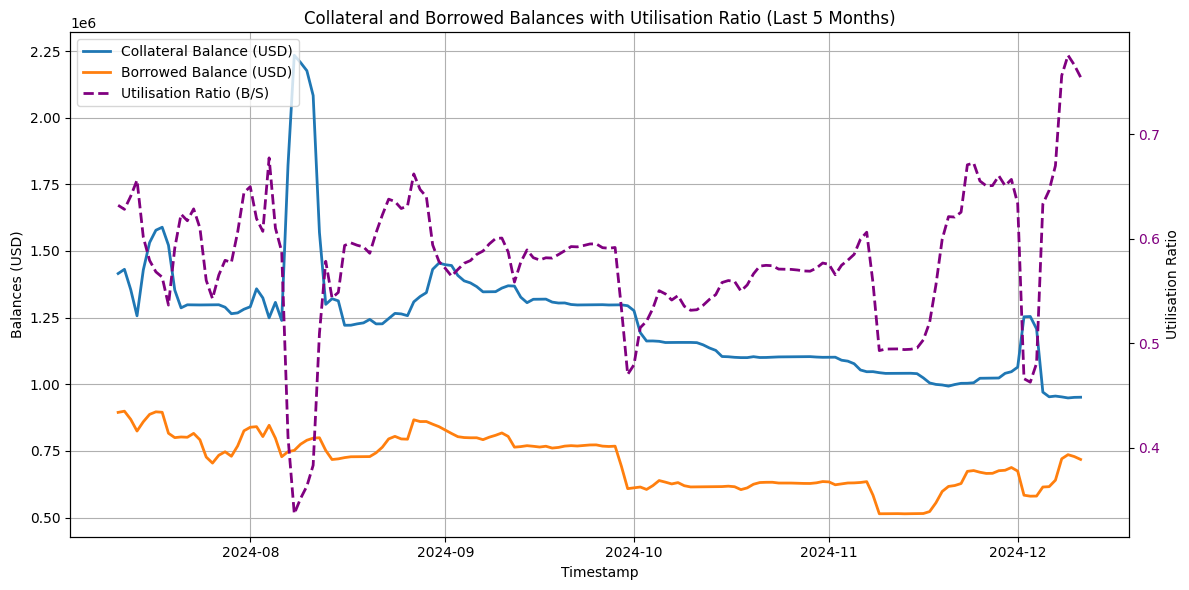

In [4]:
import matplotlib.pyplot as plt

# Calculate the utilization ratio (B/S)
df['utilisation_ratio'] = df['total_debt_usd'] / df['total_assets_usd']

# Filter data for plotting
plot_data = df[['timestamp', 'total_assets_usd', 'total_debt_usd', 'utilisation_ratio']].dropna()

filtered_data = plot_data[plot_data['timestamp'] >= plot_data['timestamp'].max() - pd.DateOffset(months=5)]

# Create a figure with twin axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total_assets_usd and total_debt_usd on the left y-axis
line1, = ax1.plot(filtered_data['timestamp'], filtered_data['total_assets_usd'], label='Collateral Balance (USD)', linewidth=2)
line2, = ax1.plot(filtered_data['timestamp'], filtered_data['total_debt_usd'], label='Borrowed Balance (USD)', linewidth=2)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Balances (USD)')
ax1.tick_params(axis='y')

# Create a second y-axis for utilisation ratio
ax2 = ax1.twinx()
line3, = ax2.plot(filtered_data['timestamp'], filtered_data['utilisation_ratio'], label='Utilisation Ratio (B/S)', color='purple', linewidth=2, linestyle='--')
ax2.set_ylabel('Utilisation Ratio')
ax2.tick_params(axis='y', labelcolor='purple')

# Combine legends from both axes
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Set title and grid
plt.title('Collateral and Borrowed Balances with Utilisation Ratio (Last 5 Months)')
ax1.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [5]:
df.head().to_clipboard()

In [6]:
### Estimate parameters using OLS and calculate volatility sigma
from scipy.stats import zscore
import numpy as np
import statsmodels.api as sm
import pandas as pd

# Filter to the last x months
data = df[df['timestamp'] >= df['timestamp'].max() - pd.DateOffset(months=5)]

# Recompute delta_utilisation for the filtered data
data['delta_utilisation'] = data['utilisation_ratio'].diff()

# Compute Z-scores for delta_utilisation and exclude outliers (Z > 2)
data = data.dropna(subset=['delta_utilisation'])
data = data[(np.abs(zscore(data['delta_utilisation'])) < 2)]

# Prepare regression data (lagged interest rate)
regression_data_x_months = data.dropna(subset=['delta_utilisation', 'rate'])
regression_data_x_months['lagged_avg_rate'] = regression_data_x_months['rate'].shift(1)
regression_data_x_months = regression_data_x_months.dropna(subset=['lagged_avg_rate'])

# Perform OLS regression
X_x_months = sm.add_constant(regression_data_x_months['lagged_avg_rate'])  # Add intercept
y_x_months = regression_data_x_months['delta_utilisation']
model_6_months = sm.OLS(y_x_months, X_x_months).fit()

# Annualize coefficients
b0_6_months_annualized = model_6_months.params['const'] * 365
b1_6_months_annualized = model_6_months.params['lagged_avg_rate'] * 365

# Calculate annualized volatility of delta_utilisation
sigma_6_months = regression_data_x_months['delta_utilisation'].std() * np.sqrt(365)

# Display regression summary and all relevant parameters
print("### Regression Summary for Last 6 Months ###")
print(model_6_months.summary())

print("\n### Derived Parameters ###")
print(f"Annualized Drift Parameter (b0): {b0_6_months_annualized:.4f}")
print(f"Annualized Borrower Sensitivity (b1): {b1_6_months_annualized:.4e}")
print(f"Annualized Volatility (σ): {sigma_6_months:.4f}")

# Return all relevant parameters for further use
b0_6_months_annualized, b1_6_months_annualized, sigma_6_months


### Regression Summary for Last 6 Months ###
                            OLS Regression Results                            
Dep. Variable:      delta_utilisation   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     5.064
Date:                Wed, 11 Dec 2024   Prob (F-statistic):             0.0260
Time:                        12:07:46   Log-Likelihood:                 358.96
No. Observations:                 145   AIC:                            -713.9
Df Residuals:                     143   BIC:                            -708.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/tmp/ipykernel_1732/2198731754.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['delta_utilisation'] = data['utilisation_ratio'].diff()


(4.840898297560445, -1.231344382792768e-09, 0.3970297032244208)

Note: Both the intercept and the coefficient of lagged interest rate are statistically significant, indicating a meaningful relationship between $ΔUt$ and the lagged average rate.

In [7]:
from src.models.utilisation_simulator import UtilizationSimulator
from src.interest_rate_models.semilog_irm import SemiLogIRM



# Initialize the SemiLogIRM model
semilog_irm = SemiLogIRM()

# Define simulation parameters
params = {
    "U0": 0.5,           # Initial utilization
    "T": 1.0,            # Total simulation time (1 year)
    "dt": 1/365,          # Time step
    "rate_model": semilog_irm.calculate_rate,  # Pass the IRM method
    "A": b1_6_months_annualized, # Borrower sensitivity
    "C": b0_6_months_annualized, # Supplier sensitivity (baseline drift)
    "r0": 0.05,          # Borrower alternative rate (fixed value) - market research 
    "r1": 0.01,          # Lender alternative rate (fixed value) - market research
    "sigma_const": sigma_6_months,  # Volatility constant
}

# Initialize the UtilizationSimulator
simulator = UtilizationSimulator(**params)

# Run the simulation
utilization_path, rate_path = simulator.simulate()

# Plot the results
import matplotlib.pyplot as plt

time = np.arange(len(utilization_path)) * params["dt"]  # Create a time array

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot utilization ratio
ax1.plot(time, utilization_path, label="Utilization Ratio", color="blue")
ax1.set_xlabel("Time (Years)")
ax1.set_ylabel("Utilization Ratio", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a secondary y-axis for interest rate
ax2 = ax1.twinx()
ax2.plot(time, rate_path, label="Interest Rate", color="red")
ax2.set_ylabel("Interest Rate", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Add title and legend
fig.suptitle("Utilization Ratio and Interest Rate Over Time")
ax1.legend(loc="lower left")
ax2.legend(loc="lower right")

plt.show()



TypeError: UtilizationSimulator.__init__() got an unexpected keyword argument 'A'

In [ ]:
####

Fitted Parameters:
rate_min: 347402866.9333029
rate_max: 25693493410.693134
R² of the fit: 0.9257461442755973


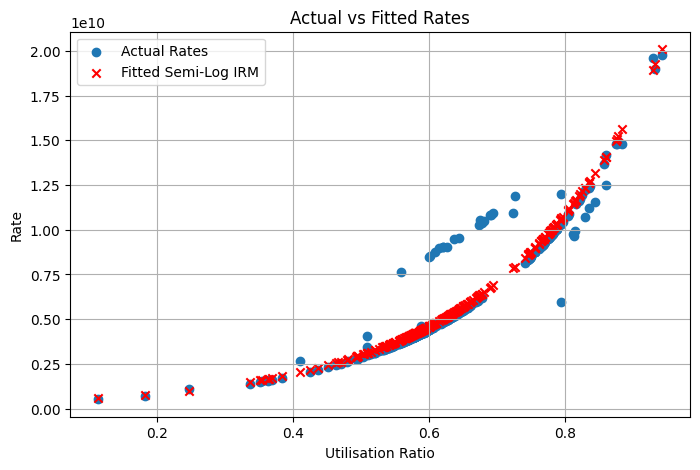

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Filter the data: Ensure utilisation is between 0 and 1 and rate > 0
df = df[(df['utilisation_ratio'] >= 0) & (df['utilisation_ratio'] <= 1) & (df['rate'] > 0)]

# Prepare variables for regression
X = df['utilisation_ratio'].values.reshape(-1, 1)
y = np.log(df['rate'].values)

# Fit a linear regression to ln(rate) vs utilisation_ratio
model = LinearRegression()
model.fit(X, y)

intercept = model.intercept_
slope = model.coef_[0]

# Recover parameters
rate_min = np.exp(intercept)
rate_max = rate_min * np.exp(slope)

print("Fitted Parameters:")
print(f"rate_min: {rate_min}")
print(f"rate_max: {rate_max}")

# Predict rates from the model
predicted_log_rate = intercept + slope * X
predicted_rate = np.exp(predicted_log_rate)

r_squared = model.score(X, y)
print(f"R² of the fit: {r_squared}")

# Plot actual vs fitted rates
plt.figure(figsize=(8,5))
plt.scatter(df['utilisation_ratio'], df['rate'], label='Actual Rates')
plt.scatter(df['utilisation_ratio'], predicted_rate, label='Fitted Semi-Log IRM', color='red', marker='x')
plt.xlabel('Utilisation Ratio')
plt.ylabel('Rate')
plt.title('Actual vs Fitted Rates')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df.sort_values('timestamp', inplace=True)

Fitted Semi-Log IRM parameters:
rate_min = 0.010955508196984574, rate_max = 0.8102751570884184
Estimated ΔU model parameters:
b0 = -0.005683979409546373
b1 = 0.01488904087856389
sigma = 0.00841001400780709


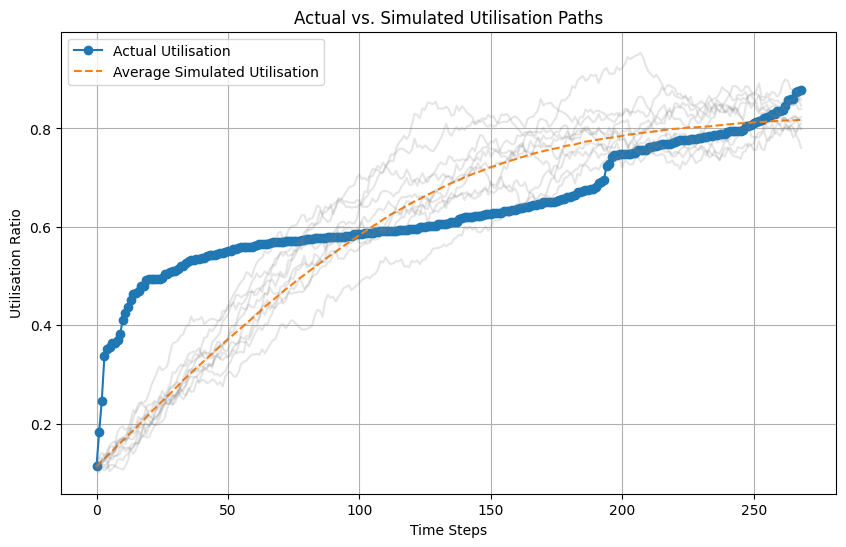

Empirical average utilisation: 0.631302285001785
Simulated average utilisation: 0.6035233044594781


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

########################################
# STEP 1: LOAD AND PREPARE DATA
########################################

# Replace this with your actual data loading step.
# We assume df has columns: 'rate' (on-chain scaled), 'utilisation_ratio', and a time index.
# df = pd.read_csv("your_data.csv")

# For demonstration, let's assume df is already loaded and contains a 'rate' column and 'utilisation_ratio'.
# The 'rate' column is per-second and scaled by 1e18.
# Convert rate to borrowAPR as per given formula:
# borrowAPR = (rate * 365 * 86400) / 1e18
df['borrowAPR'] = (df['rate'] * 365 * 86400) / 1e18

# Ensure data is sorted by time if needed
# df = df.sort_values(by='timestamp')

# Filter out invalid rows if necessary
df = df[(df['utilisation_ratio'] >= 0) & (df['utilisation_ratio'] <= 1) & (df['borrowAPR'] > 0)]

########################################
# STEP 2: FIT SEMI-LOG IRM
########################################
# We assume semi-log IRM: borrowAPR(u) = rate_min * (rate_max / rate_min)^u
# Taking logs: ln(borrowAPR) = ln(rate_min) + u * ln(rate_max/rate_min)
X = df['utilisation_ratio'].values.reshape(-1, 1)
y = np.log(df['borrowAPR'].values)

model_irm = LinearRegression()
model_irm.fit(X, y)

intercept_irm = model_irm.intercept_   # ln(rate_min)
slope_irm = model_irm.coef_[0]         # ln(rate_max/rate_min)

rate_min = np.exp(intercept_irm)
rate_max = rate_min * np.exp(slope_irm)
print("Fitted Semi-Log IRM parameters:")
print(f"rate_min = {rate_min}, rate_max = {rate_max}")

def rate_function(u):
    # Given utilisation u, return the borrowAPR from the fitted IRM
    return rate_min * (rate_max / rate_min) ** u

########################################
# STEP 3: ESTIMATE ΔU MODEL PARAMETERS
########################################
# We need consecutive daily data to compute ΔU
# Shift utilisation to get next day's utilisation
df['U_next'] = df['utilisation_ratio'].shift(-1)
df.dropna(inplace=True)  # Remove last day since it has no next day
df['Delta_U'] = df['U_next'] - df['utilisation_ratio']

# Compute r(U) for each day
df['r_u'] = df['utilisation_ratio'].apply(rate_function)

# Regress ΔU on r(U):
# ΔU = -b0 - b1*r(U) + epsilon
X_delta = df[['r_u']]
y_delta = df['Delta_U']

model_delta = LinearRegression()
model_delta.fit(X_delta, y_delta)

# model_delta.predict(r(U)) = predicted ΔU
# ΔU = -b0 - b1*r(U) => b0 = -intercept, b1 = -coef
b0 = -model_delta.intercept_
b1 = -model_delta.coef_[0]

residuals = y_delta - model_delta.predict(X_delta)
sigma = residuals.std()

print("Estimated ΔU model parameters:")
print(f"b0 = {b0}")
print(f"b1 = {b1}")
print(f"sigma = {sigma}")

########################################
# STEP 4: SIMULATE SYNTHETIC UTILISATION PATHS
########################################
# Choose a starting point and number of simulation steps.
# Let's simulate the same length as the observed sample.
num_steps = len(df)
U0 = df['utilisation_ratio'].iloc[0]  # start from first observed utilisation
num_paths = 1000

sim_paths = np.zeros((num_paths, num_steps))
for i in range(num_paths):
    U_sim = np.zeros(num_steps)
    U_sim[0] = U0
    for t in range(1, num_steps):
        current_u = U_sim[t-1]
        r_current = rate_function(current_u)
        # ΔU = -b0 - b1*r(U) + sigma * Z
        delta_u = -b0 - b1*r_current + sigma * np.random.randn()
        # Keep utilisation in [0,1]
        next_u = U_sim[t-1] + delta_u
        U_sim[t] = np.clip(next_u, 0, 1)
    sim_paths[i,:] = U_sim

avg_sim_path = sim_paths.mean(axis=0)

########################################
# STEP 5: VALIDATE AGAINST EMPIRICAL UTILISATION
########################################
emp_util = df['utilisation_ratio'].values

plt.figure(figsize=(10,6))
plt.plot(range(num_steps), emp_util, label='Actual Utilisation', marker='o')
plt.plot(range(num_steps), avg_sim_path, label='Average Simulated Utilisation', linestyle='--')

# Optionally plot a few individual simulated paths
for i in range(min(num_paths, 10)):
    plt.plot(range(num_steps), sim_paths[i,:], color='gray', alpha=0.2)

plt.xlabel('Time Steps')
plt.ylabel('Utilisation Ratio')
plt.title('Actual vs. Simulated Utilisation Paths')
plt.legend()
plt.grid(True)
plt.show()

emp_mean = np.mean(emp_util)
sim_mean = np.mean(avg_sim_path)
print("Empirical average utilisation:", emp_mean)
print("Simulated average utilisation:", sim_mean)


Empirical Utilization Std Dev: 0.12501645810643947
Simulated Average Utilization Std Dev: 0.026137723173151294


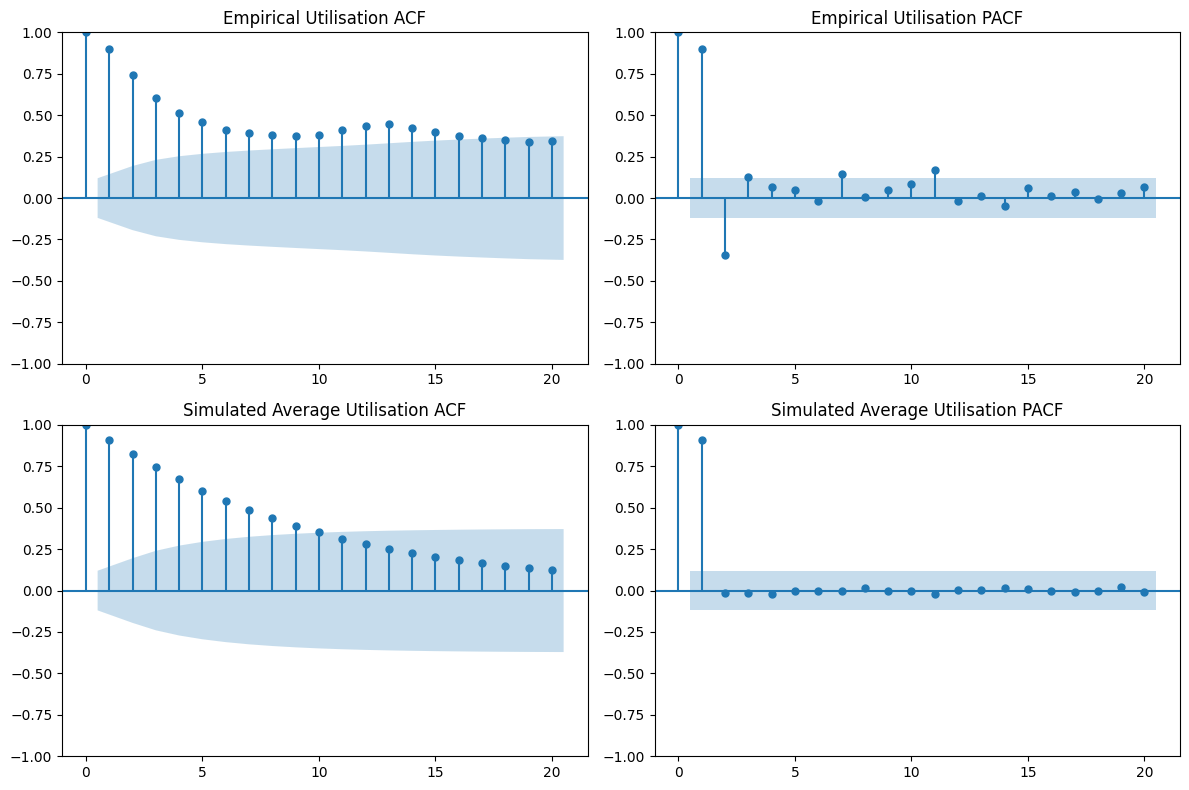

Empirical Skewness: -0.2741414098181365 Kurtosis: 1.1848715199950792
Simulated Skewness: 4.452440472359401 Kurtosis: 21.123054464761207


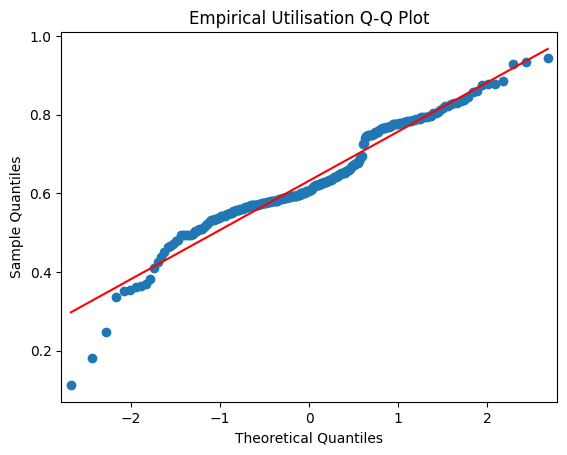

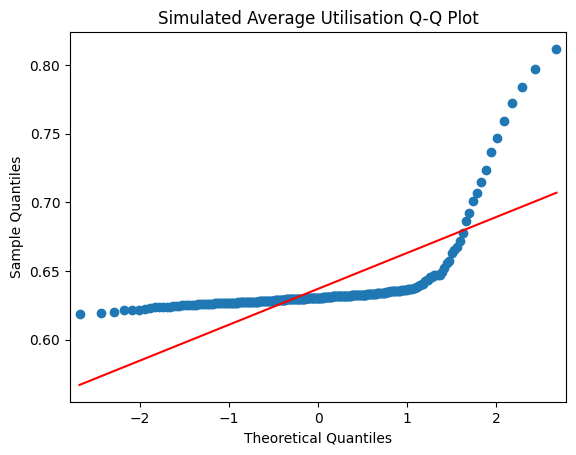

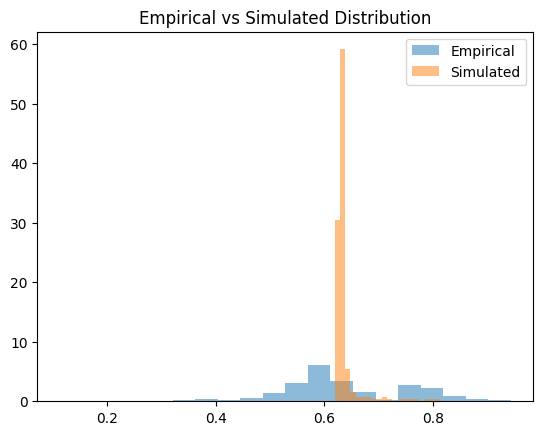

Residuals Shapiro-Wilk test: stat = 0.657496457080202 , p = 6.697712693773769e-23 (p>0.05 means residuals likely normal)
Durbin-Watson statistic for residuals: 1.3615019531093553 (~2 means no autocorrelation)


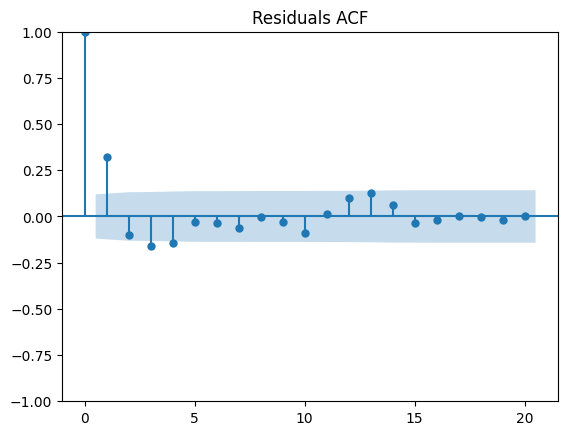

Empirical mean utilisation: 0.6320553387197099
Simulated mean utilisation: 0.6370404312853601
Empirical metrics:
Mean: 0.6320553387197099
Std Dev: 0.12501645810643947
Skewness: -0.2741414098181365
Kurtosis: 1.1848715199950792

Averaged Simulated Metrics (across all paths):
Mean: 0.6370404312853603
Std Dev: 0.12587656431334
Skewness: -0.1356302460770339
Kurtosis: -0.5057587102229685


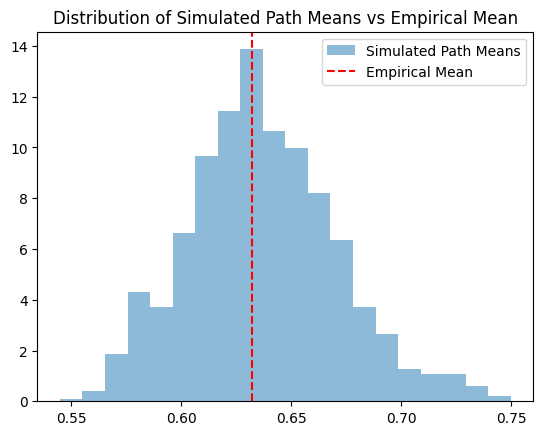

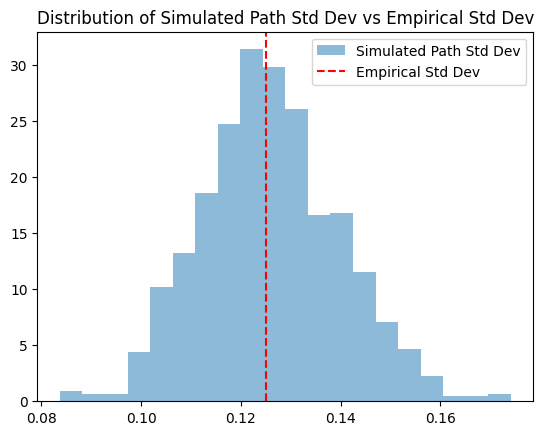

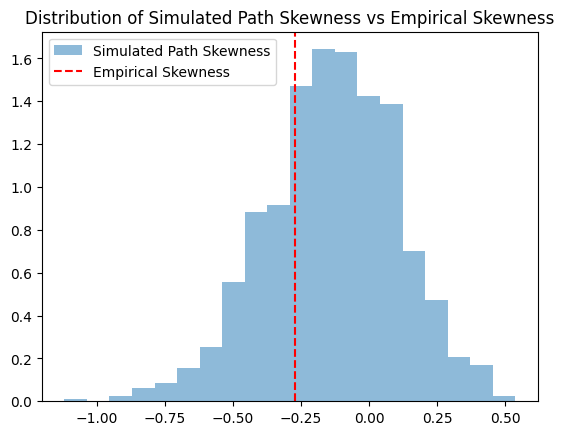

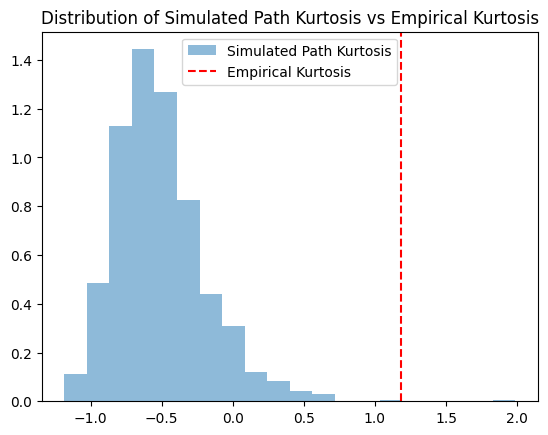

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson

########################################
# Assuming you already ran simulations and have:
# emp_util: empirical utilization array (length T)
# avg_sim_path: average simulated utilization array (length T)
# sim_paths: matrix of simulated paths (num_paths x T)
# residuals: residual array from your ΔU regression
########################################

# For demonstration here, we assume these variables are already defined.
# Replace with your actual variables:
# emp_util, avg_sim_path, sim_paths, residuals

########################################
# 1. Compare Variance and Volatility
########################################
emp_std = np.std(emp_util)
sim_std = np.std(avg_sim_path)
print("Empirical Utilization Std Dev:", emp_std)
print("Simulated Average Utilization Std Dev:", sim_std)

########################################
# 2. Autocorrelation Structure
########################################

# Plot ACF and PACF for Empirical Data
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(emp_util, ax=axes[0,0], lags=20)
axes[0,0].set_title('Empirical Utilisation ACF')
plot_pacf(emp_util, ax=axes[0,1], lags=20, method='ywm')
axes[0,1].set_title('Empirical Utilisation PACF')

# Plot ACF and PACF for Simulated Average Path
plot_acf(avg_sim_path, ax=axes[1,0], lags=20)
axes[1,0].set_title('Simulated Average Utilisation ACF')
plot_pacf(avg_sim_path, ax=axes[1,1], lags=20, method='ywm')
axes[1,1].set_title('Simulated Average Utilisation PACF')

plt.tight_layout()
plt.show()

########################################
# 3. Distributional Shape & Q-Q Plots
########################################
emp_skew = skew(emp_util)
emp_kurt = kurtosis(emp_util)
sim_skew = skew(avg_sim_path)
sim_kurt = kurtosis(avg_sim_path)
print("Empirical Skewness:", emp_skew, "Kurtosis:", emp_kurt)
print("Simulated Skewness:", sim_skew, "Kurtosis:", sim_kurt)

# QQ-plot for Empirical vs Normal
from statsmodels.graphics.gofplots import qqplot
qqplot_emp = qqplot(pd.Series(emp_util), line='s')
plt.title("Empirical Utilisation Q-Q Plot")
plt.show()

# QQ-plot for Simulated vs Normal
qqplot_sim = qqplot(pd.Series(avg_sim_path), line='s')
plt.title("Simulated Average Utilisation Q-Q Plot")
plt.show()

# Compare distributions directly (Optional)
plt.hist(emp_util, alpha=0.5, label='Empirical', bins=20, density=True)
plt.hist(avg_sim_path, alpha=0.5, label='Simulated', bins=20, density=True)
plt.title("Empirical vs Simulated Distribution")
plt.legend()
plt.show()

########################################
# 4. Residual Diagnostics (if you have residuals from ΔU regression)
########################################
# Check normality of residuals
stat, p_value = shapiro(residuals)
print("Residuals Shapiro-Wilk test: stat =", stat, ", p =", p_value, 
      "(p>0.05 means residuals likely normal)")

# Check autocorrelation in residuals
dw_stat = durbin_watson(residuals)
print("Durbin-Watson statistic for residuals:", dw_stat, 
      "(~2 means no autocorrelation)")

# Plot ACF of residuals
plot_acf(residuals, lags=20)
plt.title("Residuals ACF")
plt.show()

########################################
# 5. Equilibrium / Mean Reversion Checks
########################################
# Compare long-term means
emp_mean = np.mean(emp_util)
sim_mean = np.mean(avg_sim_path)
print("Empirical mean utilisation:", emp_mean)
print("Simulated mean utilisation:", sim_mean)

# If you have a theoretical equilibrium u*, check how often and how closely
# empirical and simulated data deviate from it:
# Example:
# u_star = some_equilibrium_value
# dev_emp = np.mean(np.abs(emp_util - u_star))
# dev_sim = np.mean(np.abs(avg_sim_path - u_star))
# print("Mean absolute deviation from equilibrium (Empirical):", dev_emp)
# print("Mean absolute deviation from equilibrium (Simulated):", dev_sim)

########################################
# 6. (Optional) Out-of-Sample Validation
########################################
# If you split your data into a training set and a test set, simulate forward
# using parameters estimated only from the training set and compare the
# simulation to the out-of-sample empirical data from the test set.

# Example (assuming you have test_util data):
# test_mean = np.mean(test_util)
# test_sim_mean = np.mean(avg_sim_path_test)
# print("Out-of-Sample Empirical Mean:", test_mean)
# print("Out-of-Sample Simulated Mean:", test_sim_mean)

########################################
# After assessing these metrics, you can draw conclusions about how well
# your simulated paths reflect the empirical utilization dynamics.
########################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson

########################################
# Assuming you have:
# emp_util: empirical utilization array
# sim_paths: array of shape (num_paths, num_steps) with simulated utilization paths
########################################

# Compute empirical metrics
emp_mean = np.mean(emp_util)
emp_std = np.std(emp_util)
emp_skew = skew(emp_util)
emp_kurt = kurtosis(emp_util)

print("Empirical metrics:")
print(f"Mean: {emp_mean}")
print(f"Std Dev: {emp_std}")
print(f"Skewness: {emp_skew}")
print(f"Kurtosis: {emp_kurt}")

# Compute metrics for each simulated path
num_paths = sim_paths.shape[0]
sim_means = np.zeros(num_paths)
sim_stds = np.zeros(num_paths)
sim_skews = np.zeros(num_paths)
sim_kurts = np.zeros(num_paths)

for i in range(num_paths):
    path = sim_paths[i, :]
    sim_means[i] = np.mean(path)
    sim_stds[i] = np.std(path)
    sim_skews[i] = skew(path)
    sim_kurts[i] = kurtosis(path)

# Average metrics across all simulated paths
avg_mean = np.mean(sim_means)
avg_std = np.mean(sim_stds)
avg_skew = np.mean(sim_skews)
avg_kurt = np.mean(sim_kurts)

print("\nAveraged Simulated Metrics (across all paths):")
print(f"Mean: {avg_mean}")
print(f"Std Dev: {avg_std}")
print(f"Skewness: {avg_skew}")
print(f"Kurtosis: {avg_kurt}")

########################################
# Compare empirical distribution with the distribution of path-level metrics
########################################

# One approach is to check how the distribution of metrics from simulated paths
# compares to the empirical metric. For example, you can visualize the distribution
# of means from all simulated paths and see if the empirical mean falls near the center.

plt.hist(sim_means, bins=20, alpha=0.5, density=True, label='Simulated Path Means')
plt.axvline(emp_mean, color='red', linestyle='--', label='Empirical Mean')
plt.title("Distribution of Simulated Path Means vs Empirical Mean")
plt.legend()
plt.show()

# Similarly, do the same for std, skewness, and kurtosis
plt.hist(sim_stds, bins=20, alpha=0.5, density=True, label='Simulated Path Std Dev')
plt.axvline(emp_std, color='red', linestyle='--', label='Empirical Std Dev')
plt.title("Distribution of Simulated Path Std Dev vs Empirical Std Dev")
plt.legend()
plt.show()

plt.hist(sim_skews, bins=20, alpha=0.5, density=True, label='Simulated Path Skewness')
plt.axvline(emp_skew, color='red', linestyle='--', label='Empirical Skewness')
plt.title("Distribution of Simulated Path Skewness vs Empirical Skewness")
plt.legend()
plt.show()

plt.hist(sim_kurts, bins=20, alpha=0.5, density=True, label='Simulated Path Kurtosis')
plt.axvline(emp_kurt, color='red', linestyle='--', label='Empirical Kurtosis')
plt.title("Distribution of Simulated Path Kurtosis vs Empirical Kurtosis")
plt.legend()
plt.show()



##### Approach Refined

Fitted Semi-Log IRM parameters:
rate_min = 0.010708636874989698, rate_max = 0.8258852442531902
Estimated W model parameters:
alpha = -0.028494067747903085
rho = 0.7289523617686455
b1 = -0.9683694657630746
sigma = 0.2705714580717793
Empirical mean utilisation: 0.6320553387197099
Simulated mean utilisation: 0.6370404312853601
Empirical Utilization Std Dev: 0.12501645810643947
Simulated Average Utilization Std Dev: 0.026137723173151294
Empirical Skewness: -0.2741414098181365 Kurtosis: 1.1848715199950792
Simulated Skewness: 4.452440472359401 Kurtosis: 21.123054464761207
Residuals Shapiro-Wilk test: stat = 0.657496457080202 , p = 6.697712693773769e-23
Durbin-Watson statistic for residuals: 1.3615019531093553


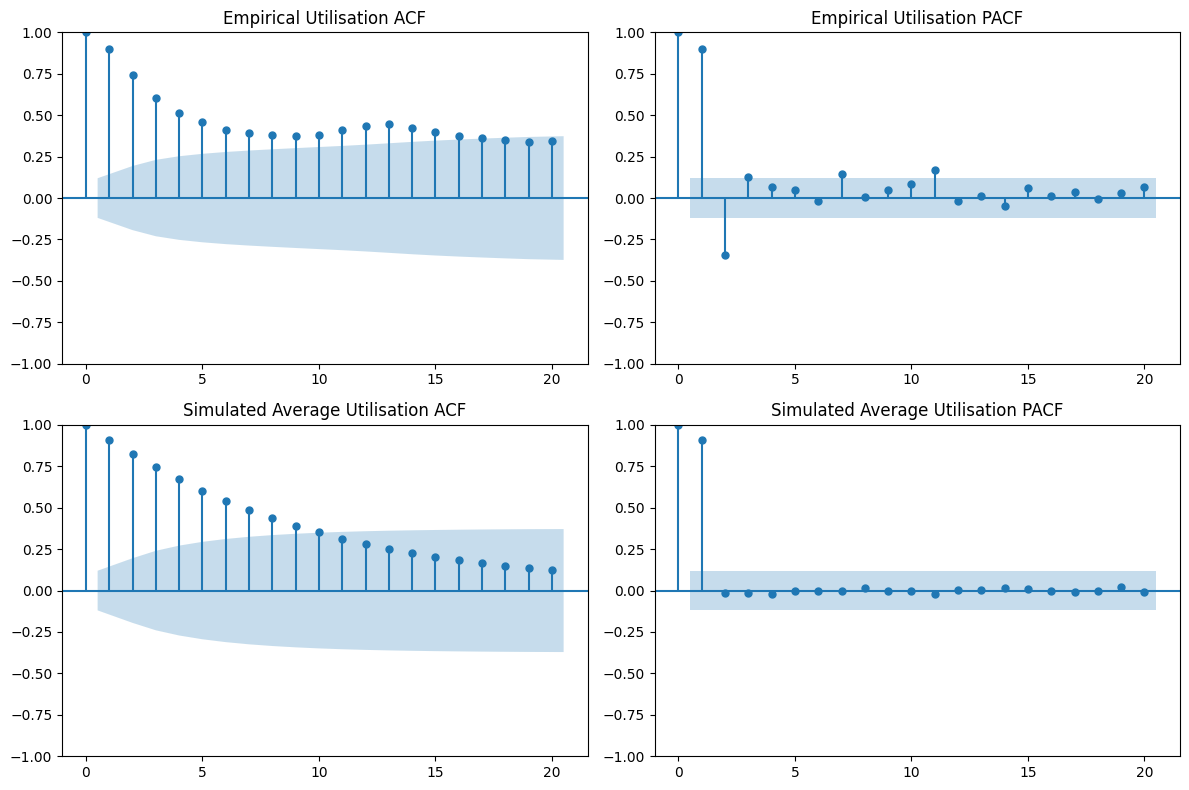

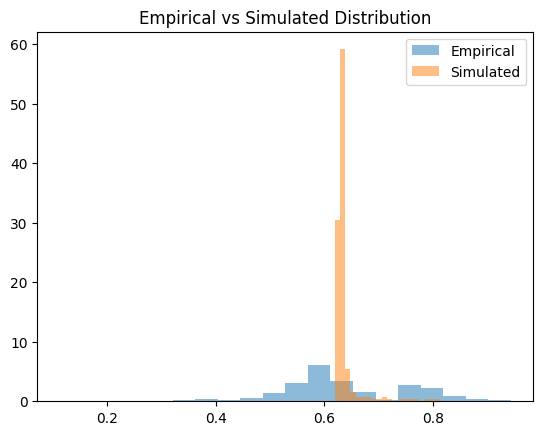

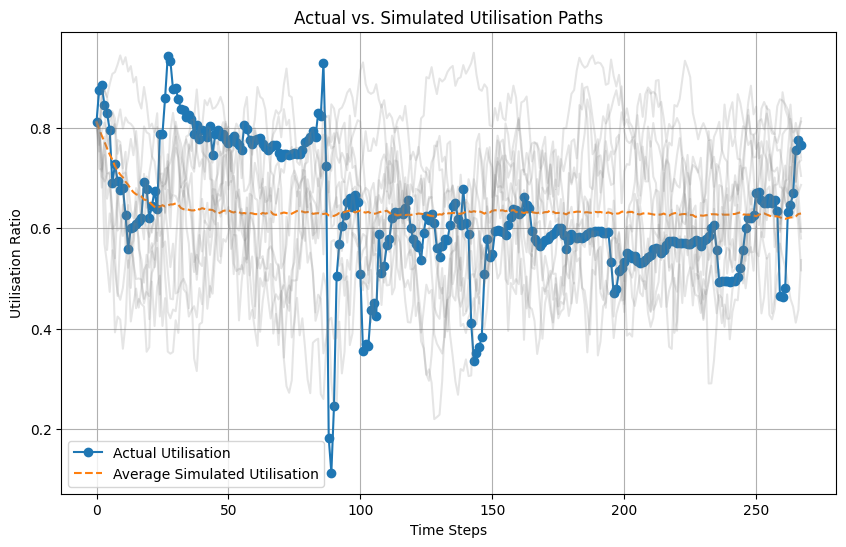

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson

########################################
# STEP 1: LOAD AND PREPARE DATA
########################################
# df = pd.read_csv("your_data.csv") 
# df should have columns: 'rate', 'timestamp', 'utilisation_ratio'

df['borrowAPR'] = (df['rate'] * 365 * 86400) / 1e18
df = df[(df['utilisation_ratio'] > 0) & (df['utilisation_ratio'] < 1) & (df['borrowAPR'] > 0)]
df = df.sort_values(by='timestamp').reset_index(drop=True)

# Logit transform of utilization
def logit(u):
    return np.log(u/(1-u))

def inv_logit(w):
    return 1/(1+np.exp(-w))

df['W'] = df['utilisation_ratio'].apply(logit)

########################################
# STEP 2: FIT SEMI-LOG IRM
########################################
X = df['utilisation_ratio'].values.reshape(-1, 1)
y = np.log(df['borrowAPR'].values)

model_irm = LinearRegression()
model_irm.fit(X, y)

intercept_irm = model_irm.intercept_
slope_irm = model_irm.coef_[0]

rate_min = np.exp(intercept_irm)
rate_max = rate_min * np.exp(slope_irm)
print("Fitted Semi-Log IRM parameters:")
print(f"rate_min = {rate_min}, rate_max = {rate_max}")

def rate_function(u):
    return rate_min * (rate_max / rate_min) ** u

########################################
# STEP 3: ESTIMATE W MODEL
########################################
# We'll model:
# W_t = alpha + rho*W_{t-1} - b1*r(U_{t-1}) + epsilon_t

df['W_lag'] = df['W'].shift(1)
df.dropna(inplace=True)

# Compute r(U_{t-1})
# We have W_{t-1}, invert to get U_{t-1}
df['U_lag'] = inv_logit(df['W_lag'])
df['r_u_lag'] = df['U_lag'].apply(rate_function)

X_w = df[['W_lag', 'r_u_lag']].values
y_w = df['W'].values

model_w = LinearRegression()
model_w.fit(X_w, y_w)

alpha = model_w.intercept_
rho, neg_b1 = model_w.coef_
b1 = -neg_b1

residuals = y_w - model_w.predict(X_w)
sigma = residuals.std()

print("Estimated W model parameters:")
print(f"alpha = {alpha}")
print(f"rho = {rho}")
print(f"b1 = {b1}")
print(f"sigma = {sigma}")

########################################
# STEP 4: SIMULATE SYNTHETIC W PATHS AND INVERT BACK TO U
########################################
num_steps = len(df)
W0 = df['W'].iloc[0]
num_paths = 1000

sim_W_paths = np.zeros((num_paths, num_steps))
for i in range(num_paths):
    W_sim = np.zeros(num_steps)
    W_sim[0] = W0
    for t in range(1, num_steps):
        current_w = W_sim[t-1]
        # Compute current U from W
        current_u = inv_logit(current_w)
        r_current = rate_function(current_u)
        # W_t = alpha + rho*W_{t-1} - b1*r(U_{t-1}) + sigma * Z
        W_t = alpha + rho*current_w - b1*r_current + sigma*np.random.randn()
        W_sim[t] = W_t
    sim_W_paths[i,:] = W_sim

# Convert back to U
sim_paths = inv_logit(sim_W_paths)
avg_sim_path = sim_paths.mean(axis=0)
emp_util = df['utilisation_ratio'].values

########################################
# STEP 5: VALIDATE AGAIN
########################################
emp_mean = np.mean(emp_util)
sim_mean = np.mean(avg_sim_path)
print("Empirical mean utilisation:", emp_mean)
print("Simulated mean utilisation:", sim_mean)

emp_std = np.std(emp_util)
sim_std = np.std(avg_sim_path)
print("Empirical Utilization Std Dev:", emp_std)
print("Simulated Average Utilization Std Dev:", sim_std)

emp_skew = skew(emp_util)
emp_kurt = kurtosis(emp_util)
sim_skew = skew(avg_sim_path)
sim_kurt = kurtosis(avg_sim_path)
print("Empirical Skewness:", emp_skew, "Kurtosis:", emp_kurt)
print("Simulated Skewness:", sim_skew, "Kurtosis:", sim_kurt)

stat, p_value = shapiro(residuals)
print("Residuals Shapiro-Wilk test: stat =", stat, ", p =", p_value)

dw_stat = durbin_watson(residuals)
print("Durbin-Watson statistic for residuals:", dw_stat)

# ACF/PACF
fig, axes = plt.subplots(2, 2, figsize=(12,8))
plot_acf(emp_util, ax=axes[0,0], lags=20)
axes[0,0].set_title('Empirical Utilisation ACF')
plot_pacf(emp_util, ax=axes[0,1], lags=20, method='ywm')
axes[0,1].set_title('Empirical Utilisation PACF')

plot_acf(avg_sim_path, ax=axes[1,0], lags=20)
axes[1,0].set_title('Simulated Average Utilisation ACF')
plot_pacf(avg_sim_path, ax=axes[1,1], lags=20, method='ywm')
axes[1,1].set_title('Simulated Average Utilisation PACF')

plt.tight_layout()
plt.show()

# Distribution Comparison
plt.hist(emp_util, alpha=0.5, label='Empirical', bins=20, density=True)
plt.hist(avg_sim_path, alpha=0.5, label='Simulated', bins=20, density=True)
plt.title("Empirical vs Simulated Distribution")
plt.legend()
plt.show()

# Paths Comparison
plt.figure(figsize=(10,6))
plt.plot(range(num_steps), emp_util, label='Actual Utilisation', marker='o')
plt.plot(range(num_steps), avg_sim_path, label='Average Simulated Utilisation', linestyle='--')
for i in range(min(num_paths, 10)):
    plt.plot(range(num_steps), sim_paths[i,:], color='gray', alpha=0.2)
plt.xlabel('Time Steps')
plt.ylabel('Utilisation Ratio')
plt.title('Actual vs. Simulated Utilisation Paths')
plt.legend()
plt.grid(True)
plt.show()


Empirical metrics:
Mean: 0.6320553387197099
Std Dev: 0.12501645810643947
Skewness: -0.2741414098181365
Kurtosis: 1.1848715199950792

Averaged Simulated Metrics (across all paths):
Mean: 0.6370404312853603
Std Dev: 0.12587656431334
Skewness: -0.1356302460770339
Kurtosis: -0.5057587102229685


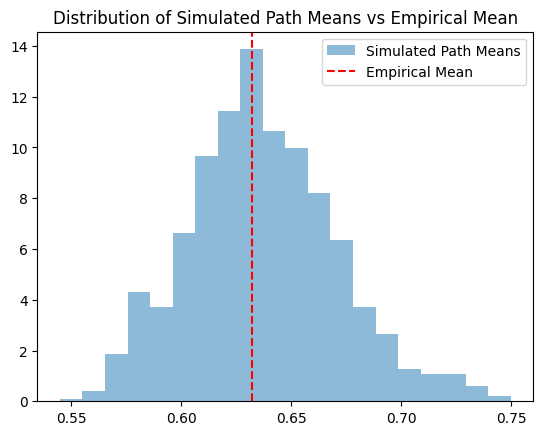

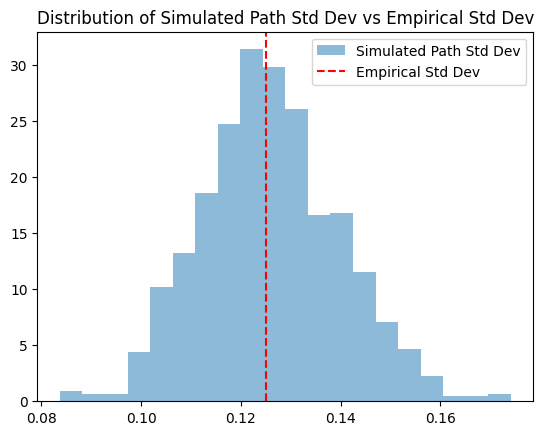

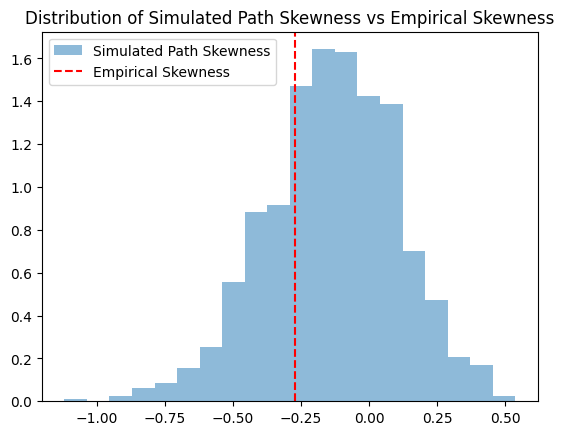

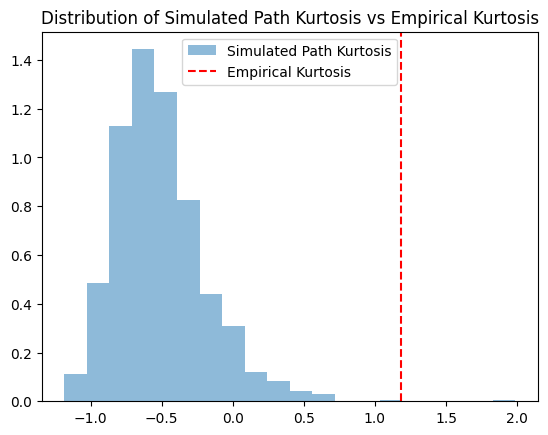

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson

########################################
# Assuming you have:
# emp_util: empirical utilization array
# sim_paths: array of shape (num_paths, num_steps) with simulated utilization paths
########################################

# Compute empirical metrics
emp_mean = np.mean(emp_util)
emp_std = np.std(emp_util)
emp_skew = skew(emp_util)
emp_kurt = kurtosis(emp_util)

print("Empirical metrics:")
print(f"Mean: {emp_mean}")
print(f"Std Dev: {emp_std}")
print(f"Skewness: {emp_skew}")
print(f"Kurtosis: {emp_kurt}")

# Compute metrics for each simulated path
num_paths = sim_paths.shape[0]
sim_means = np.zeros(num_paths)
sim_stds = np.zeros(num_paths)
sim_skews = np.zeros(num_paths)
sim_kurts = np.zeros(num_paths)

for i in range(num_paths):
    path = sim_paths[i, :]
    sim_means[i] = np.mean(path)
    sim_stds[i] = np.std(path)
    sim_skews[i] = skew(path)
    sim_kurts[i] = kurtosis(path)

# Average metrics across all simulated paths
avg_mean = np.mean(sim_means)
avg_std = np.mean(sim_stds)
avg_skew = np.mean(sim_skews)
avg_kurt = np.mean(sim_kurts)

print("\nAveraged Simulated Metrics (across all paths):")
print(f"Mean: {avg_mean}")
print(f"Std Dev: {avg_std}")
print(f"Skewness: {avg_skew}")
print(f"Kurtosis: {avg_kurt}")

########################################
# Compare empirical distribution with the distribution of path-level metrics
########################################

# One approach is to check how the distribution of metrics from simulated paths
# compares to the empirical metric. For example, you can visualize the distribution
# of means from all simulated paths and see if the empirical mean falls near the center.

plt.hist(sim_means, bins=20, alpha=0.5, density=True, label='Simulated Path Means')
plt.axvline(emp_mean, color='red', linestyle='--', label='Empirical Mean')
plt.title("Distribution of Simulated Path Means vs Empirical Mean")
plt.legend()
plt.show()

# Similarly, do the same for std, skewness, and kurtosis
plt.hist(sim_stds, bins=20, alpha=0.5, density=True, label='Simulated Path Std Dev')
plt.axvline(emp_std, color='red', linestyle='--', label='Empirical Std Dev')
plt.title("Distribution of Simulated Path Std Dev vs Empirical Std Dev")
plt.legend()
plt.show()

plt.hist(sim_skews, bins=20, alpha=0.5, density=True, label='Simulated Path Skewness')
plt.axvline(emp_skew, color='red', linestyle='--', label='Empirical Skewness')
plt.title("Distribution of Simulated Path Skewness vs Empirical Skewness")
plt.legend()
plt.show()

plt.hist(sim_kurts, bins=20, alpha=0.5, density=True, label='Simulated Path Kurtosis')
plt.axvline(emp_kurt, color='red', linestyle='--', label='Empirical Kurtosis')
plt.title("Distribution of Simulated Path Kurtosis vs Empirical Kurtosis")
plt.legend()
plt.show()


Fitted Semi-Log IRM parameters:
rate_min = 0.01079349377921439
rate_max = 0.8206847836306571

Estimated Baseline ΔW model parameters:
alpha = -0.02849853052258972
rho = -0.2707166205554469
b1 = -0.9694190606319049
sigma = 0.2699860708932531

Estimated jump intensity (λ): 0.02214022140221402
Estimated jump size mean (μ_J): -0.304629284641049
Estimated jump size std dev (σ_J): 1.5136192329461444

Empirical Metrics:
Mean: 0.6340171541824507
Std Dev: 0.1257839716011849
Skewness: -0.27630579986132514
Kurtosis: 1.1139168432875861

Averaged Simulated Metrics (across all paths):
Mean: 0.6375469029238157
Std Dev: 0.14994440156135871
Skewness: -0.33328707012809644
Kurtosis: -0.029776776753150457


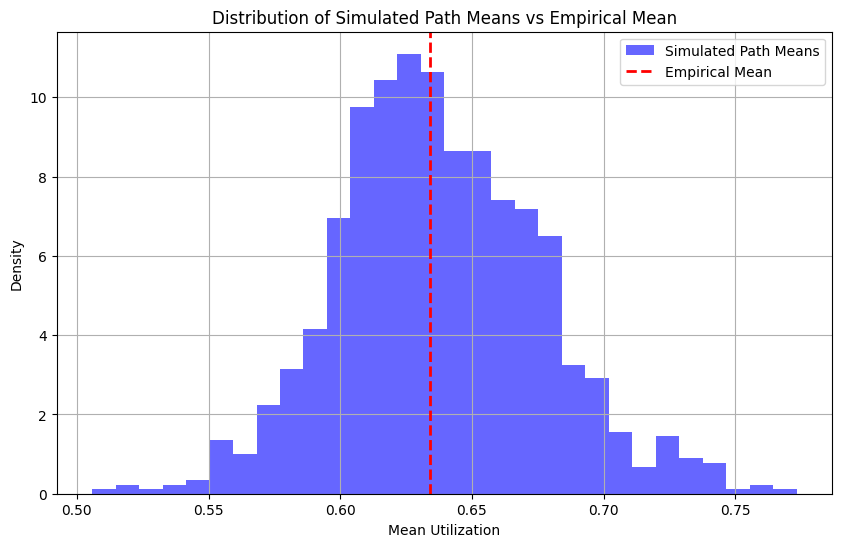

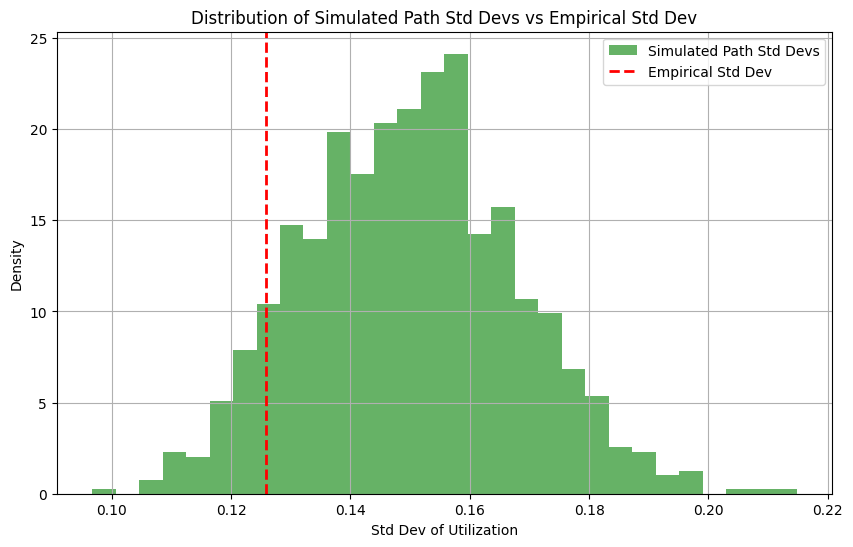

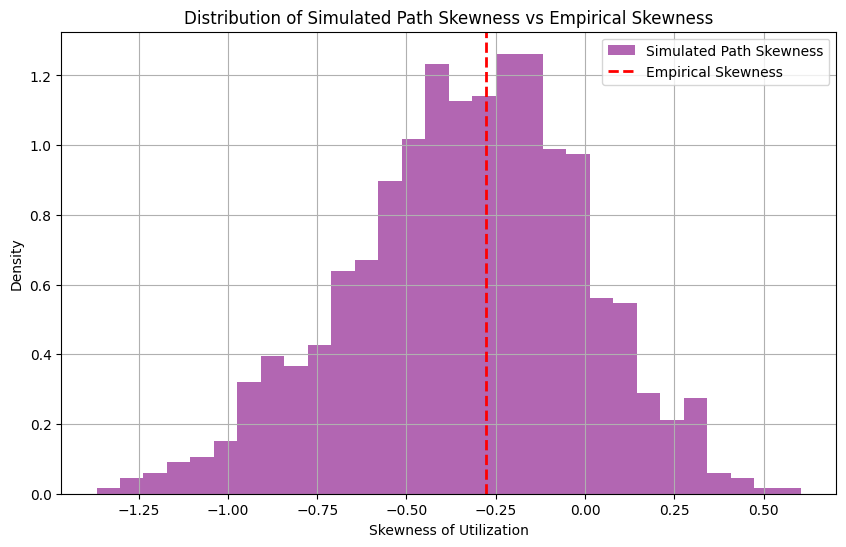

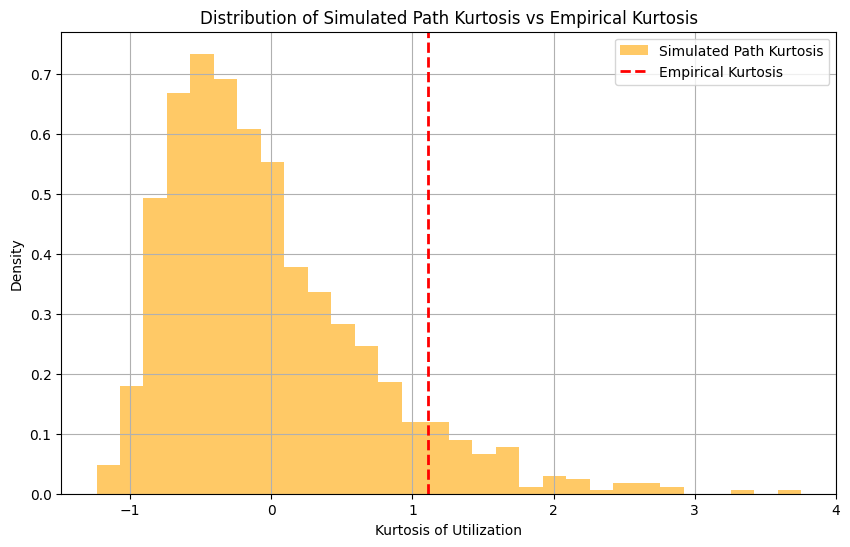


Residuals Diagnostics:
Shapiro-Wilk test: stat = 0.6623810101587216, p = 7.057181639662918e-23
Durbin-Watson statistic: 1.370294954037507


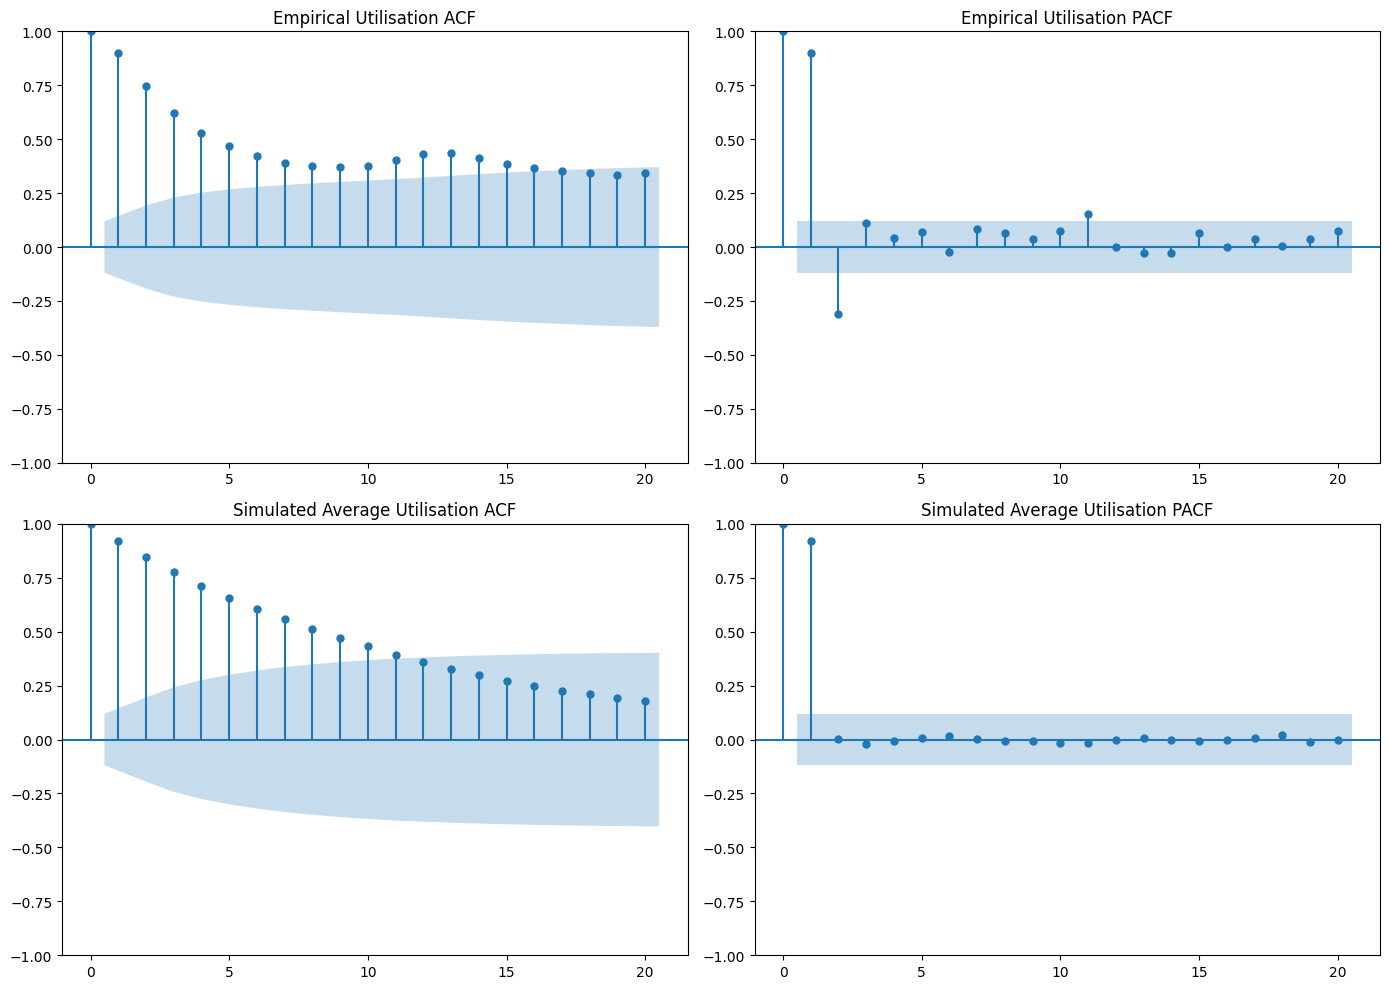

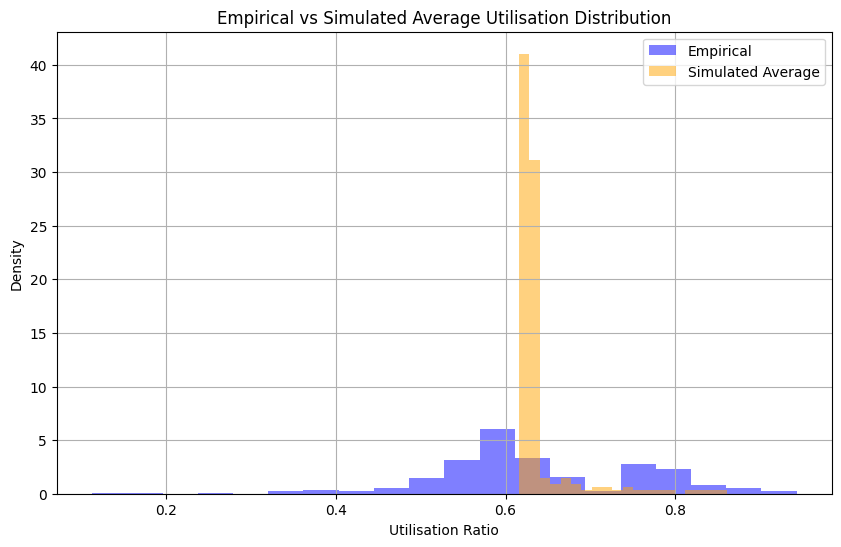

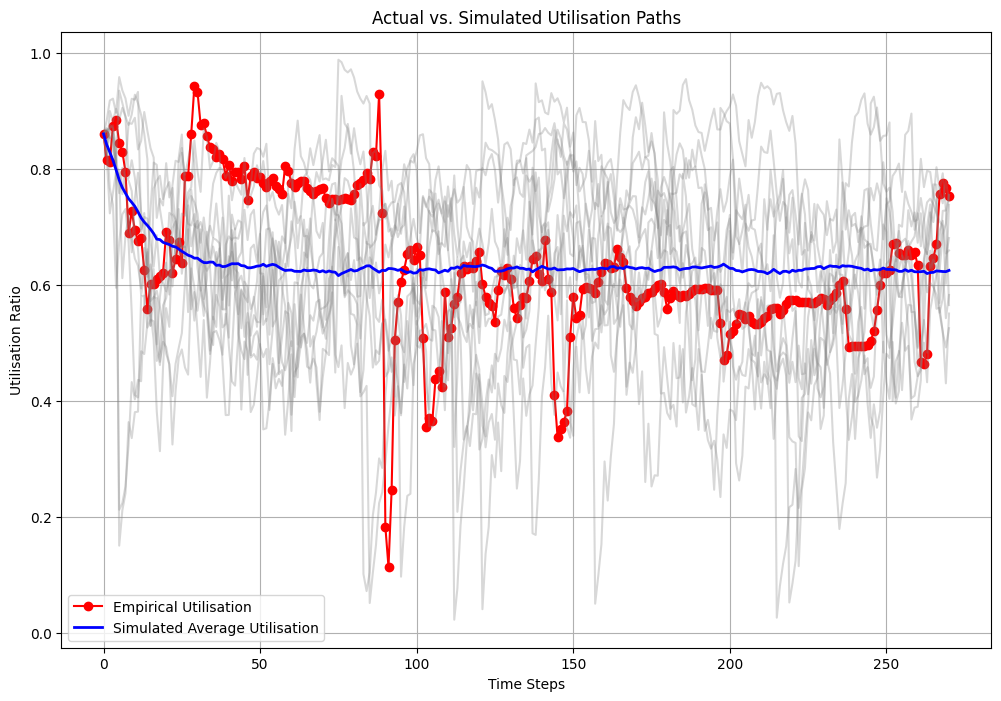

In [68]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from scipy.stats import skew, kurtosis, shapiro
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.graphics.gofplots import qqplot
# from statsmodels.stats.stattools import durbin_watson

# # ============================================
# # STEP 1: LOAD AND PREPARE DATA
# # ============================================

# # Replace this with your actual data loading step
# # For example, if your data is in a CSV file:
# # df = pd.read_csv("llamalend_data.csv")

# # Example data based on your initial input (for demonstration purposes)


# # Convert 'timestamp' to datetime if not already
# df['timestamp'] = pd.to_datetime(df['timestamp'])

# # Convert rate to borrowAPR as per provided formula:
# # borrowAPR = (rate * 365 * 86400) / 1e18
# df['borrowAPR'] = (df['rate'] * 365 * 86400) / 1e18

# # Filter data: utilisation_ratio must be between 0 and 1 (exclusive), and borrowAPR > 0
# df = df[(df['utilisation_ratio'] > 0) & (df['utilisation_ratio'] < 1) & (df['borrowAPR'] > 0)]

# # Sort by timestamp
# df = df.sort_values(by='timestamp').reset_index(drop=True)

# # Logit transformation function and its inverse
# def logit(u):
#     return np.log(u / (1 - u))

# def inv_logit(w):
#     return 1 / (1 + np.exp(-w))

# # Apply logit transformation to utilisation_ratio
# df['W'] = df['utilisation_ratio'].apply(logit)

# # ============================================
# # STEP 2: FIT SEMI-LOG IRM
# # ============================================

# # Semi-Log IRM: ln(borrowAPR) = ln(rate_min) + u * ln(rate_max / rate_min)
# X_irm = df['utilisation_ratio'].values.reshape(-1, 1)
# y_irm = np.log(df['borrowAPR'].values)

# model_irm = LinearRegression()
# model_irm.fit(X_irm, y_irm)

# intercept_irm = model_irm.intercept_
# slope_irm = model_irm.coef_[0]

# rate_min = np.exp(intercept_irm)
# rate_max = rate_min * np.exp(slope_irm)

# print("Fitted Semi-Log IRM parameters:")
# print(f"rate_min = {rate_min}")
# print(f"rate_max = {rate_max}")

# def rate_function(u):
#     """Calculate borrowAPR based on utilisation ratio using fitted Semi-Log IRM."""
#     return rate_min * (rate_max / rate_min) ** u

# # ============================================
# # STEP 3: ESTIMATE BASELINE ΔW MODEL (Without Jumps)
# # ============================================

# # Compute lagged W and ΔW
# df['W_lag'] = df['W'].shift(1)
# df['Delta_W'] = df['W'] - df['W_lag']

# # Drop the first row with NaN lag
# df = df.dropna(subset=['W_lag']).reset_index(drop=True)

# # Exogenous variables: U_lag and r(U_lag)
# df['U_lag'] = inv_logit(df['W_lag'])
# df['r_u_lag'] = df['U_lag'].apply(rate_function)

# # Prepare regression variables
# X_w = df[['W_lag', 'r_u_lag']].values
# y_w = df['Delta_W'].values

# # Fit the baseline ΔW model
# model_w = LinearRegression()
# model_w.fit(X_w, y_w)

# alpha = model_w.intercept_
# rho, neg_b1 = model_w.coef_
# b1 = -neg_b1
# residuals = y_w - model_w.predict(X_w)
# sigma = residuals.std()

# print("\nEstimated Baseline ΔW model parameters:")
# print(f"alpha = {alpha}")
# print(f"rho = {rho}")
# print(f"b1 = {b1}")
# print(f"sigma = {sigma}")

# # ============================================
# # STEP 4: IDENTIFY JUMPS IN RESIDUALS
# # ============================================

# # Define jump detection threshold (e.g., 3 standard deviations)
# threshold = 3 * residuals.std()

# # Identify jumps: residuals beyond the threshold
# jump_indices = df.index[abs(residuals) > threshold].tolist()
# M = len(jump_indices)
# T = len(df)

# # Estimate jump intensity (λ)
# lambda_jump = M / T
# print(f"\nEstimated jump intensity (λ): {lambda_jump}")

# # Extract jump sizes (residuals beyond threshold)
# jump_sizes = residuals[jump_indices]

# # Estimate jump size distribution parameters (mean and std)
# mu_J = jump_sizes.mean()
# sigma_J = jump_sizes.std(ddof=1)
# print(f"Estimated jump size mean (μ_J): {mu_J}")
# print(f"Estimated jump size std dev (σ_J): {sigma_J}")

# # ============================================
# # STEP 5: SIMULATE SYNTHETIC UTILISATION PATHS WITH JUMPS
# # ============================================

# # Simulation parameters
# num_paths = 1000
# num_steps = len(df)
# W0 = df['W'].iloc[0]  # Starting point
# np.random.seed(42)  # For reproducibility

# # Precompute rates for efficiency
# rates = df['utilisation_ratio'].apply(rate_function).values

# # Initialize simulation storage
# sim_W_paths = np.zeros((num_paths, num_steps))
# sim_W_paths[:, 0] = W0

# # Simulate each path
# for i in range(num_paths):
#     for t in range(1, num_steps):
#         current_W = sim_W_paths[i, t-1]
#         current_U = inv_logit(current_W)
#         r_current = rate_function(current_U)
        
#         # Baseline ΔW
#         delta_W = alpha + rho * current_W - b1 * r_current + sigma * np.random.randn()
        
#         # Determine if a jump occurs
#         if np.random.rand() < lambda_jump:
#             # Draw jump from jump size distribution (Gaussian)
#             J_t = np.random.normal(mu_J, sigma_J)
#             delta_W += J_t
        
#         # Update W with ΔW, ensuring it remains within (-inf, inf) due to logit
#         sim_W_paths[i, t] = sim_W_paths[i, t-1] + delta_W

# # Convert simulated W back to U
# sim_U_paths = inv_logit(sim_W_paths)

# # ============================================
# # STEP 6: VALIDATE SIMULATED PATHS
# # ============================================

# # Empirical utilization
# emp_util = df['utilisation_ratio'].values

# # Compute metrics for each simulated path
# sim_means = sim_U_paths.mean(axis=1)
# sim_stds = sim_U_paths.std(axis=1)
# sim_skews = skew(sim_U_paths, axis=1)
# sim_kurts = kurtosis(sim_U_paths, axis=1)

# # Compute average metrics across all simulated paths
# avg_sim_mean = sim_means.mean()
# avg_sim_std = sim_stds.mean()
# avg_sim_skew = sim_skews.mean()
# avg_sim_kurt = sim_kurts.mean()

# print("\nEmpirical Metrics:")
# print(f"Mean: {emp_util.mean()}")
# print(f"Std Dev: {emp_util.std()}")
# print(f"Skewness: {skew(emp_util)}")
# print(f"Kurtosis: {kurtosis(emp_util)}")

# print("\nAveraged Simulated Metrics (across all paths):")
# print(f"Mean: {avg_sim_mean}")
# print(f"Std Dev: {avg_sim_std}")
# print(f"Skewness: {avg_sim_skew}")
# print(f"Kurtosis: {avg_sim_kurt}")

# # Compare individual metrics distributions
# # Histograms for Means
# plt.figure(figsize=(10, 6))
# plt.hist(sim_means, bins=30, alpha=0.6, color='blue', density=True, label='Simulated Path Means')
# plt.axvline(emp_util.mean(), color='red', linestyle='dashed', linewidth=2, label='Empirical Mean')
# plt.title("Distribution of Simulated Path Means vs Empirical Mean")
# plt.xlabel("Mean Utilization")
# plt.ylabel("Density")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Histograms for Std Devs
# plt.figure(figsize=(10, 6))
# plt.hist(sim_stds, bins=30, alpha=0.6, color='green', density=True, label='Simulated Path Std Devs')
# plt.axvline(emp_util.std(), color='red', linestyle='dashed', linewidth=2, label='Empirical Std Dev')
# plt.title("Distribution of Simulated Path Std Devs vs Empirical Std Dev")
# plt.xlabel("Std Dev of Utilization")
# plt.ylabel("Density")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Histograms for Skewness
# plt.figure(figsize=(10, 6))
# plt.hist(sim_skews, bins=30, alpha=0.6, color='purple', density=True, label='Simulated Path Skewness')
# plt.axvline(skew(emp_util), color='red', linestyle='dashed', linewidth=2, label='Empirical Skewness')
# plt.title("Distribution of Simulated Path Skewness vs Empirical Skewness")
# plt.xlabel("Skewness of Utilization")
# plt.ylabel("Density")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Histograms for Kurtosis
# plt.figure(figsize=(10, 6))
# plt.hist(sim_kurts, bins=30, alpha=0.6, color='orange', density=True, label='Simulated Path Kurtosis')
# plt.axvline(kurtosis(emp_util), color='red', linestyle='dashed', linewidth=2, label='Empirical Kurtosis')
# plt.title("Distribution of Simulated Path Kurtosis vs Empirical Kurtosis")
# plt.xlabel("Kurtosis of Utilization")
# plt.ylabel("Density")
# plt.legend()
# plt.grid(True)
# plt.show()

# # ============================================
# # STEP 7: RESIDUAL DIAGNOSTICS
# # ============================================

# # Analyze residuals from the baseline ΔW model
# print("\nResiduals Diagnostics:")
# print(f"Shapiro-Wilk test: stat = {shapiro(residuals)[0]}, p = {shapiro(residuals)[1]}")
# print(f"Durbin-Watson statistic: {durbin_watson(residuals)}")

# # ACF and PACF for Empirical and Simulated Data
# # Compute average simulated path
# avg_sim_path = sim_U_paths.mean(axis=0)

# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# # ACF and PACF for Empirical Utilization
# plot_acf(emp_util, ax=axes[0,0], lags=20)
# axes[0,0].set_title('Empirical Utilisation ACF')
# plot_pacf(emp_util, ax=axes[0,1], lags=20, method='ywm')
# axes[0,1].set_title('Empirical Utilisation PACF')

# # ACF and PACF for Simulated Average Utilisation
# plot_acf(avg_sim_path, ax=axes[1,0], lags=20)
# axes[1,0].set_title('Simulated Average Utilisation ACF')
# plot_pacf(avg_sim_path, ax=axes[1,1], lags=20, method='ywm')
# axes[1,1].set_title('Simulated Average Utilisation PACF')

# plt.tight_layout()
# plt.show()

# # Distribution Comparison: Empirical vs Simulated
# plt.figure(figsize=(10, 6))
# plt.hist(emp_util, bins=20, alpha=0.5, label='Empirical', density=True, color='blue')
# plt.hist(avg_sim_path, bins=20, alpha=0.5, label='Simulated Average', density=True, color='orange')
# plt.title("Empirical vs Simulated Average Utilisation Distribution")
# plt.xlabel("Utilisation Ratio")
# plt.ylabel("Density")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Paths Comparison: Plot a few simulated paths against empirical
# plt.figure(figsize=(12, 8))
# plt.plot(range(num_steps), emp_util, label='Empirical Utilisation', marker='o', color='red')
# for i in range(min(num_paths, 10)):
#     plt.plot(range(num_steps), sim_U_paths[i,:], color='gray', alpha=0.3)
# plt.plot(range(num_steps), avg_sim_path, label='Simulated Average Utilisation', color='blue', linewidth=2)
# plt.xlabel('Time Steps')
# plt.ylabel('Utilisation Ratio')
# plt.title('Actual vs. Simulated Utilisation Paths')
# plt.legend()
# plt.grid(True)
# plt.show()


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pybetareg #import BetaReg
from scipy.stats import beta
from sklearn.linear_model import LinearRegression


########################################
# STEP 1: LOAD AND PREPARE DATA
########################################

# Assuming df is your DataFrame with 'timestamp', 'utilisation_ratio', 'rate'
# Convert rate to borrowAPR as before:
df['borrowAPR'] = (df['rate'] * 365 * 86400) / 1e18

# Filter data to ensure utilisation_ratio in (0,1):
df = df[(df['utilisation_ratio'] > 0) & (df['utilisation_ratio'] < 1)]

df = df.sort_values(by='timestamp').reset_index(drop=True)

########################################
# STEP 2: FIT SEMI-LOG IRM
########################################
X = df['utilisation_ratio'].values.reshape(-1, 1)
y = np.log(df['borrowAPR'].values)

model_irm = LinearRegression()
model_irm.fit(X, y)

intercept_irm = model_irm.intercept_
slope_irm = model_irm.coef_[0]

rate_min = np.exp(intercept_irm)
rate_max = rate_min * np.exp(slope_irm)
print("Fitted Semi-Log IRM parameters:")
print(f"rate_min = {rate_min}, rate_max = {rate_max}")

def rate_function(u):
    return rate_min * (rate_max / rate_min) ** u


# Create lagged utilization
df['U_lag'] = df['utilisation_ratio'].shift(1)
df.dropna(inplace=True)

# Compute r(U_{t-1}) and its square
df['r_u_lag'] = df['U_lag'].apply(rate_function)
df['r_u_lag_sq'] = df['r_u_lag']**2

########################################
# STEP 2: FIT BETA REGRESSION
########################################
# Formula: utilisation_ratio ~ U_lag + r_u_lag + r_u_lag_sq
# Link function: logit (default)
model = pybetareg.BetaReg.from_formula("utilisation_ratio ~ U_lag + r_u_lag + r_u_lag_sq", data=df, link='logit')
res = model.fit()

print(res.summary())

########################################
# STEP 3: VALIDATE MODEL FIT
########################################
# Predict mean (mu) and precision (phi)
mu_pred = res.predict(which='mean')
phi_pred = res.predict(which='precision')

emp_util = df['utilisation_ratio'].values

# Compute statistics
emp_mean = np.mean(emp_util)
emp_std = np.std(emp_util)
emp_skew = (np.mean((emp_util - emp_mean)**3)) / (emp_std**3)
emp_kurt = (np.mean((emp_util - emp_mean)**4)) / (emp_std**4)

print("Empirical mean:", emp_mean)
print("Empirical std:", emp_std)
print("Empirical skewness:", emp_skew)
print("Empirical kurtosis:", emp_kurt)

mu_mean = np.mean(mu_pred)
mu_std = np.std(mu_pred)
print("Mean of predicted mu:", mu_mean)
print("Std of predicted mu:", mu_std)

########################################
# STEP 4: SIMULATE SYNTHETIC PATHS
########################################
# To simulate:
# For each time step:
#   1. Given U_{t-1}, compute r(U_{t-1}) and r(U_{t-1})^2
#   2. Compute linear predictor for mu_t
#   3. Compute mu_t and phi (use res.predict with a constructed DataFrame)
#   4. Sample U_t from Beta(alpha=mu_t*phi, beta=(1-mu_t)*phi)

num_steps = len(df)
num_paths = 1000

# Create a function to predict mu, phi given U_{t-1}
def predict_params(U_prev):
    r_val = rate_function(U_prev)
    new_data = pd.DataFrame({'U_lag': [U_prev], 'r_u_lag': [r_val], 'r_u_lag_sq': [r_val**2]})
    print(new_data)

    mu = res.predict(new_data, which='mean')[0]
    phi = res.predict(new_data, which='precision')[0]
    return mu, phi

# Start from first observation in df
U0 = df['utilisation_ratio'].iloc[0]

sim_paths = np.zeros((num_paths, num_steps))
for i in range(num_paths):
    U_sim = np.zeros(num_steps)
    U_sim[0] = U0
    for t in range(1, num_steps):
        mu_t, phi_t = predict_params(U_sim[t-1])
        alpha_t = mu_t * phi_t
        beta_t = (1 - mu_t) * phi_t
        U_sim[t] = beta.rvs(alpha_t, beta_t)
    sim_paths[i,:] = U_sim

avg_sim_path = sim_paths.mean(axis=0)

########################################
# STEP 5: COMPARE SIMULATED TO EMPIRICAL
########################################
sim_mean = np.mean(avg_sim_path)
sim_std = np.std(avg_sim_path)
sim_skew = (np.mean((avg_sim_path - sim_mean)**3)) / (sim_std**3)
sim_kurt = (np.mean((avg_sim_path - sim_mean)**4)) / (sim_std**4)

print("Simulated mean:", sim_mean)
print("Simulated std:", sim_std)
print("Simulated skewness:", sim_skew)
print("Simulated kurtosis:", sim_kurt)

plt.figure(figsize=(10,6))
plt.plot(emp_util, label='Empirical Utilisation')
plt.plot(avg_sim_path, label='Average Simulated Utilisation', linestyle='--')
plt.title('Actual vs. Simulated Utilisation Paths (Beta Regression)')
plt.xlabel('Time Steps')
plt.ylabel('Utilisation Ratio')
plt.legend()
plt.grid(True)
plt.show()

# Distribution Comparison
plt.hist(emp_util, alpha=0.5, label='Empirical', bins=20, density=True)
plt.hist(avg_sim_path, alpha=0.5, label='Simulated', bins=20, density=True)
plt.title("Empirical vs Simulated Distribution")
plt.legend()
plt.show()


Fitted Semi-Log IRM parameters:
rate_min = 0.010517956753054671, rate_max = 0.8376858093625225


AttributeError: module 'pybetareg' has no attribute 'BetaReg'

Fitted Semi-Log IRM parameters:
rate_min = 0.010960297458683564, rate_max = 0.8099258531457916
                              BetaModel Results                               
Dep. Variable:      utilisation_ratio   Log-Likelihood:                 380.19
Model:                      BetaModel   AIC:                            -754.4
Method:            Maximum Likelihood   BIC:                            -743.5
Date:                Wed, 11 Dec 2024                                         
Time:                        16:28:54                                         
No. Observations:                 273                                         
Df Residuals:                     269                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
U_lag         -2.0422      0.218    

/home/xm3van/.local/lib/python3.11/site-packages/statsmodels/base/model.py:2748: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "


Simulated mean: 0.6605832060326663
Simulated std: 0.028571042231715357
Simulated skewness: 2.9192788372365643
Simulated kurtosis: 13.516064918876891


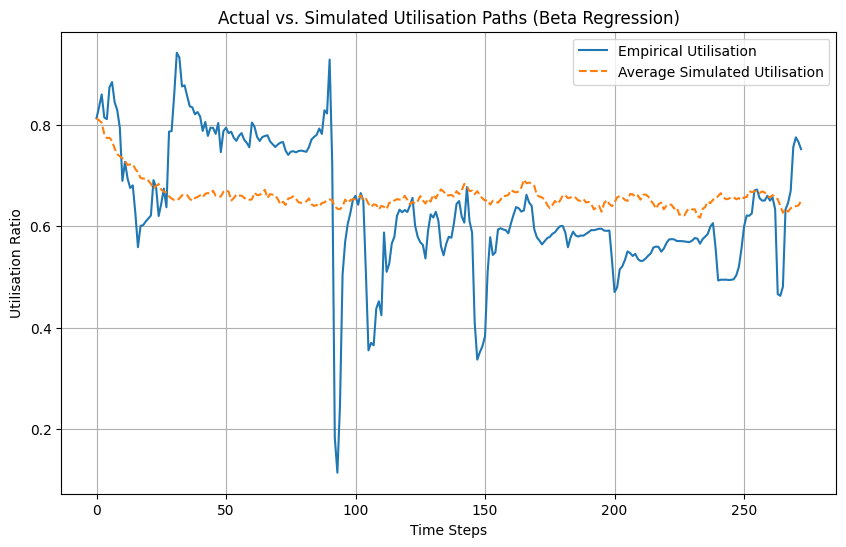

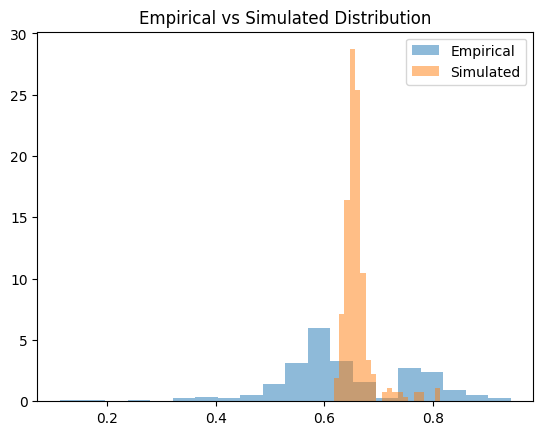

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from sklearn.linear_model import LinearRegression
from statsmodels.othermod.betareg import BetaModel

df = retrieve_lending_market()
df['utilisation_ratio'] = df['total_debt_usd'] / df['total_assets_usd']


########################################
# STEP 1: LOAD AND PREPARE DATA
########################################

# Assuming df is your DataFrame with 'timestamp', 'utilisation_ratio', 'rate'
# Convert rate to borrowAPR as before:
df['borrowAPR'] = (df['rate'] * 365 * 86400) / 1e18

# Filter data to ensure utilisation_ratio in (0,1):
df = df[(df['utilisation_ratio'] > 0) & (df['utilisation_ratio'] < 1)]

df = df.sort_values(by='timestamp').reset_index(drop=True)

########################################
# STEP 2: FIT SEMI-LOG IRM
########################################
X = df['utilisation_ratio'].values.reshape(-1, 1)
y = np.log(df['borrowAPR'].values)

model_irm = LinearRegression()
model_irm.fit(X, y)

intercept_irm = model_irm.intercept_
slope_irm = model_irm.coef_[0]

rate_min = np.exp(intercept_irm)
rate_max = rate_min * np.exp(slope_irm)
print("Fitted Semi-Log IRM parameters:")
print(f"rate_min = {rate_min}, rate_max = {rate_max}")

def rate_function(u):
    return rate_min * (rate_max / rate_min) ** u

# Create lagged utilization
df['U_lag'] = df['utilisation_ratio'].shift(1)
df.dropna(inplace=True)

# Compute r(U_{t-1}) and its square
df['r_u_lag'] = df['U_lag'].apply(rate_function)
df['r_u_lag_sq'] = df['r_u_lag']**2

########################################
# STEP 2: FIT BETA REGRESSION
########################################
# Formula: utilisation_ratio ~ U_lag + r_u_lag + r_u_lag_sq
# Using BetaModel from statsmodels

X_beta = df[['U_lag', 'r_u_lag', 'r_u_lag_sq']]
y_beta = df['utilisation_ratio']

model = BetaModel(y_beta, X_beta)
res = model.fit()

print(res.summary())

########################################
# STEP 3: VALIDATE MODEL FIT
########################################
# Predict mean (mu) and precision (phi)
mu_pred = res.predict(which='mean')
phi_pred = res.predict(which='precision')

emp_util = df['utilisation_ratio'].values

# Compute statistics
emp_mean = np.mean(emp_util)
emp_std = np.std(emp_util)
emp_skew = (np.mean((emp_util - emp_mean)**3)) / (emp_std**3)
emp_kurt = (np.mean((emp_util - emp_mean)**4)) / (emp_std**4)

print("Empirical mean:", emp_mean)
print("Empirical std:", emp_std)
print("Empirical skewness:", emp_skew)
print("Empirical kurtosis:", emp_kurt)

mu_mean = np.mean(mu_pred)
mu_std = np.std(mu_pred)
print("Mean of predicted mu:", mu_mean)
print("Std of predicted mu:", mu_std)

########################################
# STEP 4: SIMULATE SYNTHETIC PATHS
########################################
# To simulate:
# For each time step:
#   1. Given U_{t-1}, compute r(U_{t-1}) and r(U_{t-1})^2
#   2. Compute linear predictor for mu_t
#   3. Compute mu_t and phi (use res.predict with a constructed DataFrame)
#   4. Sample U_t from Beta(alpha=mu_t*phi, beta=(1-mu_t)*phi)

num_steps = len(df)
num_paths = 100

# Create a function to predict mu, phi given U_{t-1}
# def predict_params(U_prev):
#     # Compute rate values
#     r_val = rate_function(U_prev)
#     # Create a single-row DataFrame for prediction
#     new_data = pd.DataFrame({'U_lag': [U_prev], 'r_u_lag': [r_val], 'r_u_lag_sq': [r_val**2]})
#     # Predict mu and phi for the new data row
#     print(f"mean: {res.predict(new_data, which='mean')[0]}")
#     print(f"precision: {res.predict(new_data, which='precision')}")
#     mu = res.model.predict_mu(new_data).item()  # Use model's predict_mu directly
#     phi = res.model.predict_phi(new_data).item()  # Use model's predict_phi directly
#     return mu, phi

# def predict_params(U_prev):
#     # Compute rate values
#     r_val = rate_function(U_prev)
#     # Construct a single-row DataFrame for prediction
#     new_data = pd.DataFrame({
#         'U_lag': [U_prev],
#         'r_u_lag': [r_val],
#         'r_u_lag_sq': [r_val**2]
#     })
    
#     # Reset index to avoid index issues
#     new_data.reset_index(drop=True, inplace=True)

#     # Predict the mean (mu)
#     mu = res.predict(new_data, which='mean').iloc[0]

#     # Calculate the precision (phi)
#     # Extract precision coefficients
#     precision_params = res.model.exog_precision.dot(res.params[-len(res.model.exog_precision.T):])
#     phi = np.exp(precision_params[0])  # Apply exponential transformation to ensure positivity
#     print(mu, phi)
#     return mu, phi

def predict_params(U_prev):
    # Compute rate values
    r_val = rate_function(U_prev)
    # Construct a single-row DataFrame for prediction
    new_data = pd.DataFrame({
        'U_lag': [U_prev],
        'r_u_lag': [r_val],
        'r_u_lag_sq': [r_val**2]
    })

    # Reset index to avoid index issues
    new_data.reset_index(drop=True, inplace=True)

    # Predict the mean (mu)
    mu = res.predict(new_data, which='mean').iloc[0]

    # Calculate the precision (phi)
    linear_phi = res.params.precision  # Intercept
    # Transform to precision (phi) using exp
    phi = np.exp(linear_phi)

    # Ensure validity
    # mu = np.clip(mu, 1e-6, 1 - 1e-6)  # Avoid 0 or 1 for mu
    # phi = max(phi, 1e-6)  # Ensure phi is positive

    # print(f"mu: {mu}, phi: {phi}")
    return mu, phi




# Start from first observation in df
# Start from the first observation
U0 = df['utilisation_ratio'].iloc[0]

sim_paths = np.zeros((num_paths, num_steps))
for i in range(num_paths):
    U_sim = np.zeros(num_steps)
    U_sim[0] = U0
    for t in range(1, num_steps):
        mu_t, phi_t = predict_params(U_sim[t-1])
        alpha_t = mu_t * phi_t
        beta_t = (1 - mu_t) * phi_t
        U_sim[t] = beta.rvs(alpha_t, beta_t)
    sim_paths[i, :] = U_sim


# Calculate average simulated path after the simulation loop
avg_sim_path = sim_paths.mean(axis=0)


########################################
# STEP 5: COMPARE SIMULATED TO EMPIRICAL
########################################
sim_mean = np.mean(avg_sim_path)
sim_std = np.std(avg_sim_path)
sim_skew = (np.mean((avg_sim_path - sim_mean)**3)) / (sim_std**3)
sim_kurt = (np.mean((avg_sim_path - sim_mean)**4)) / (sim_std**4)

print("Simulated mean:", sim_mean)
print("Simulated std:", sim_std)
print("Simulated skewness:", sim_skew)
print("Simulated kurtosis:", sim_kurt)

plt.figure(figsize=(10,6))
plt.plot(emp_util, label='Empirical Utilisation')
plt.plot(avg_sim_path, label='Average Simulated Utilisation', linestyle='--')
plt.title('Actual vs. Simulated Utilisation Paths (Beta Regression)')
plt.xlabel('Time Steps')
plt.ylabel('Utilisation Ratio')
plt.legend()
plt.grid(True)
plt.show()

# Distribution Comparison
plt.hist(emp_util, alpha=0.5, label='Empirical', bins=20, density=True)
plt.hist(avg_sim_path, alpha=0.5, label='Simulated', bins=20, density=True)
plt.title("Empirical vs Simulated Distribution")
plt.legend()
plt.show()



Fitted Semi-Log IRM parameters:
rate_min = 0.010960297458683564, rate_max = 0.8099258531457916
                              BetaModel Results                               
Dep. Variable:      utilisation_ratio   Log-Likelihood:                 380.19
Model:                      BetaModel   AIC:                            -754.4
Method:            Maximum Likelihood   BIC:                            -743.5
Date:                Wed, 11 Dec 2024                                         
Time:                        16:33:25                                         
No. Observations:                 273                                         
Df Residuals:                     269                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
U_lag         -2.0422      0.218    

/home/xm3van/.local/lib/python3.11/site-packages/statsmodels/base/model.py:2748: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "


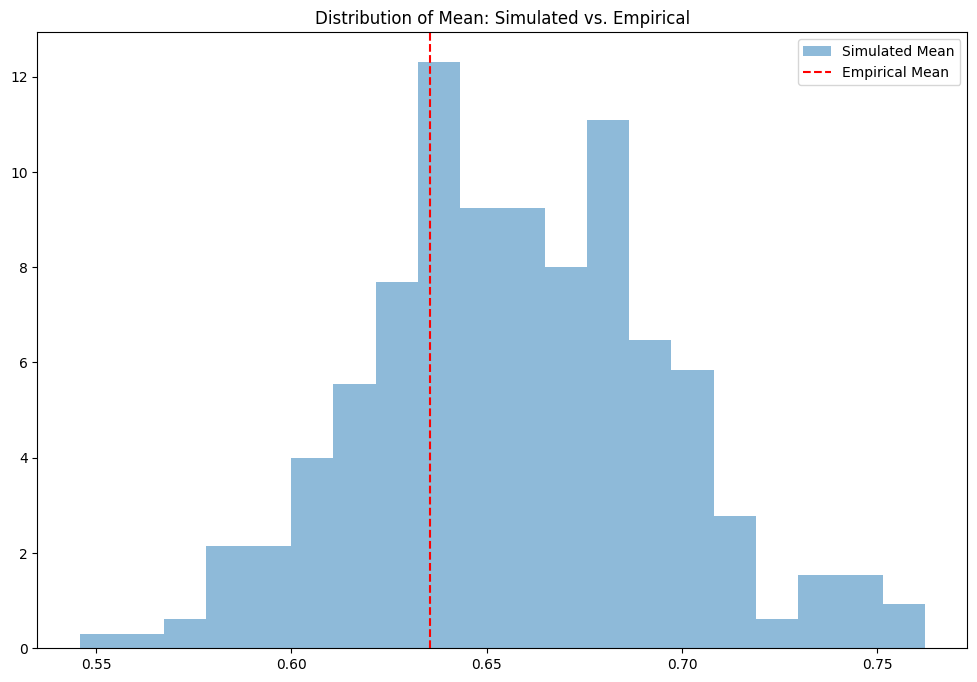

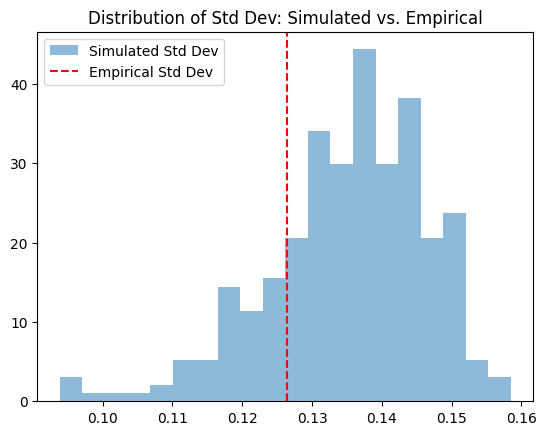

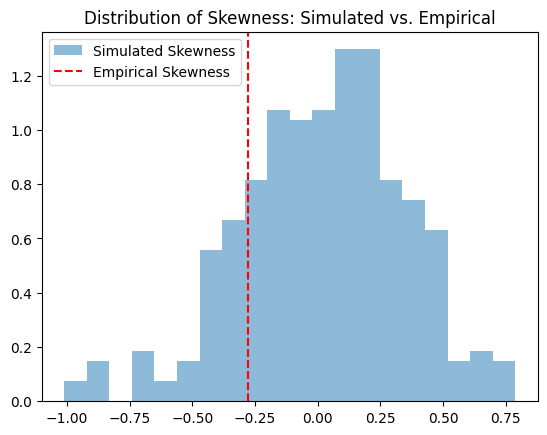

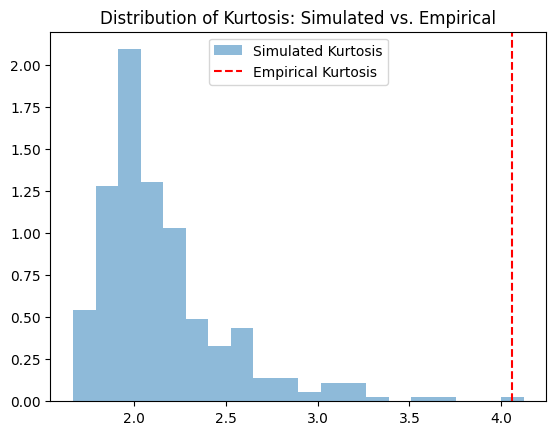

Statistical Tests
Mean - KS Test Statistic: 0.7066666666666667, p-value: 2.904637389937505e-72
Std Dev - KS Test Statistic: 0.7966666666666666, p-value: 3.6354757087208926e-95
Skewness - KS Test Statistic: 0.8233333333333334, p-value: 5.66990990078276e-103
Kurtosis - KS Test Statistic: 0.9966666666666667, p-value: 8.88178727519808e-177
RMSE between simulated and empirical statistics: 0.9642593907892885


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, skew, kurtosis, ks_2samp, chisquare
from sklearn.linear_model import LinearRegression
from statsmodels.othermod.betareg import BetaModel

df = retrieve_lending_market()
df['utilisation_ratio'] = df['total_debt_usd'] / df['total_assets_usd']

########################################
# STEP 1: LOAD AND PREPARE DATA
########################################

# Assuming df is your DataFrame with 'timestamp', 'utilisation_ratio', 'rate'
# Convert rate to borrowAPR as before:
df['borrowAPR'] = (df['rate'] * 365 * 86400) / 1e18

# Filter data to ensure utilisation_ratio in (0,1):
df = df[(df['utilisation_ratio'] > 0) & (df['utilisation_ratio'] < 1)]

df = df.sort_values(by='timestamp').reset_index(drop=True)

########################################
# STEP 2: FIT SEMI-LOG IRM
########################################
X = df['utilisation_ratio'].values.reshape(-1, 1)
y = np.log(df['borrowAPR'].values)

model_irm = LinearRegression()
model_irm.fit(X, y)

intercept_irm = model_irm.intercept_
slope_irm = model_irm.coef_[0]

rate_min = np.exp(intercept_irm)
rate_max = rate_min * np.exp(slope_irm)
print("Fitted Semi-Log IRM parameters:")
print(f"rate_min = {rate_min}, rate_max = {rate_max}")

def rate_function(u):
    return rate_min * (rate_max / rate_min) ** u

# Create lagged utilization
df['U_lag'] = df['utilisation_ratio'].shift(1)
df.dropna(inplace=True)

# Compute r(U_{t-1}) and its square
df['r_u_lag'] = df['U_lag'].apply(rate_function)
df['r_u_lag_sq'] = df['r_u_lag']**2

########################################
# STEP 2: FIT BETA REGRESSION
########################################
# Formula: utilisation_ratio ~ U_lag + r_u_lag + r_u_lag_sq
# Using BetaModel from statsmodels

X_beta = df[['U_lag', 'r_u_lag', 'r_u_lag_sq']]
y_beta = df['utilisation_ratio']

model = BetaModel(y_beta, X_beta)
res = model.fit()

print(res.summary())

########################################
# STEP 3: VALIDATE MODEL FIT
########################################
# Predict mean (mu) and precision (phi)
def predict_params(U_prev):
    # Compute rate values
    r_val = rate_function(U_prev)
    # Construct a single-row DataFrame for prediction
    new_data = pd.DataFrame({
        'U_lag': [U_prev],
        'r_u_lag': [r_val],
        'r_u_lag_sq': [r_val**2]
    })

    # Reset index to avoid index issues
    new_data.reset_index(drop=True, inplace=True)

    # Predict the mean (mu)
    mu = res.predict(new_data, which='mean').iloc[0]

    # Use the static precision parameter
    linear_phi = res.params['precision']
    phi = np.exp(linear_phi)

    # Ensure validity
    mu = np.clip(mu, 1e-6, 1 - 1e-6)  # Avoid 0 or 1 for mu
    phi = max(phi, 1e-6)  # Ensure phi is positive

    return mu, phi

emp_util = df['utilisation_ratio'].values

########################################
# STEP 4: SIMULATE SYNTHETIC PATHS
########################################
num_steps = len(df)
num_paths = 300

# Start from the first observation
U0 = df['utilisation_ratio'].iloc[0]

sim_paths = np.zeros((num_paths, num_steps))
for i in range(num_paths):
    U_sim = np.zeros(num_steps)
    U_sim[0] = U0
    for t in range(1, num_steps):
        mu_t, phi_t = predict_params(U_sim[t-1])
        alpha_t = mu_t * phi_t
        beta_t = (1 - mu_t) * phi_t
        U_sim[t] = beta.rvs(alpha_t, beta_t)
    sim_paths[i, :] = U_sim

# Calculate average simulated path after the simulation loop
avg_sim_path = sim_paths.mean(axis=0)

########################################
# STEP 5: COMPARE SIMULATED TO EMPIRICAL
########################################
# Compute statistics for each simulated path
sim_stats = []
for path in sim_paths:
    mean = np.mean(path)
    std = np.std(path)
    skewness = skew(path)
    kurt = kurtosis(path, fisher=False)  # Pearson kurtosis
    sim_stats.append([mean, std, skewness, kurt])

sim_stats = np.array(sim_stats)

# Compute empirical statistics
empirical_stats = [
    np.mean(emp_util),
    np.std(emp_util),
    skew(emp_util),
    kurtosis(emp_util, fisher=False)
]

# Visualize distributions of simulated statistics vs empirical
labels = ['Mean', 'Std Dev', 'Skewness', 'Kurtosis']

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.hist(sim_stats[:, i], bins=20, alpha=0.5, label=f"Simulated {labels[i]}", density=True)
    plt.axvline(empirical_stats[i], color='red', linestyle='--', label=f"Empirical {labels[i]}")
    plt.title(f"Distribution of {labels[i]}: Simulated vs. Empirical")
    plt.legend()
    plt.show()

# Perform statistical tests to compare distributions
print("Statistical Tests")
for i, label in enumerate(labels):
    stat, p_value = ks_2samp(sim_stats[:, i], [empirical_stats[i]] * len(sim_stats))
    print(f"{label} - KS Test Statistic: {stat}, p-value: {p_value}")

# Compute RMSE between simulated and empirical statistics
rmse = np.sqrt(np.mean((sim_stats.mean(axis=0) - empirical_stats)**2))
print("RMSE between simulated and empirical statistics:", rmse)